<a href="https://colab.research.google.com/github/johannesmichael/CAS-AML-MD3/blob/main/ElemRL_enemy02-jeremy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Elementary Reinforcement Learning**

Objectives: understanting the usage of environments in the [OpenAI Gym](https://www.gymlibrary.dev/) framework and  implement basic RL algorithms

1.   Manage to create custom environments from the OpenAI Gym framework
2.   Train Q-Learning on one of the custom environments and perform analysis regarding hyper-parameters







Install needed Python packages

In [ ]:
!pip install pygame gym numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Import needed Python packages

In [ ]:
import gym
from gym import spaces
import pygame
import numpy as np

Mount Google Drive for saving results (not needed if running the notebook locally)

In [ ]:
# Mount Google Drive
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"         # default location for the drive

drive.mount(ROOT)              # we mount the google drive at /content/drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **1) Create Custom Environments**


## Definition of a simple grid environment 
The agent needs to reach a target location in the grid represented by the target. 
For the documentation of the `gym.Env` class visit: https://www.gymlibrary.dev/api/core/#gym-env

Implemented methods for this class are: 

*   `__init__` needed for setting all basic variables of the environment
*   `step` and `reset` for respectively making a step into the agent-environment loop and resetting to initial state
*   `render` needed for visualization purposes
*   `_render_frame` private method for rendering frames 
* `_get_obs` and `_get_info` are private methods needed for returning observations and info

The environment for a squared grid of size 5 looks like this:

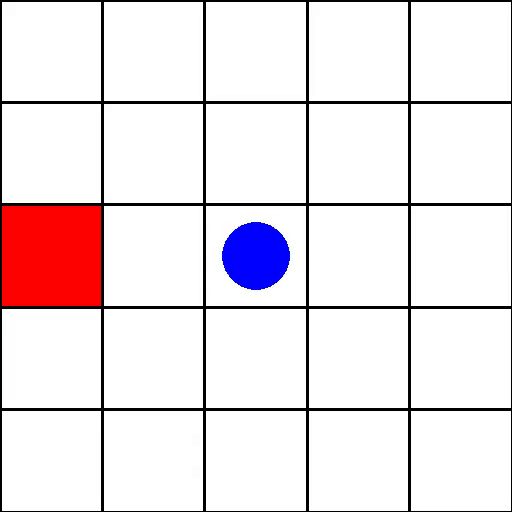

# Enemy knows position of agent and moves toward it

In [ ]:
class GridWorldEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

    def __init__(self, render_mode=None, size=5):
        self.size = size  # The size of the square grid
        self.window_size = 512  # The size of the PyGame window

        # Observations are dictionaries with the agent's and the target's location.
        # Each location is encoded as an element of {0, ..., `size`}^2, i.e. MultiDiscrete([size, size]).
        self.observation_space = spaces.Dict(
            {
                "agent": spaces.Box(0, size - 1, shape=(2,), dtype=int),
                "target": spaces.Box(0, size - 1, shape=(2,), dtype=int),
                "enemy": spaces.Box(0, size - 1, shape=(2,), dtype=int),
            }
        )

        # We have 4 actions, corresponding to "right", "up", "left", "down"
        self.action_space = spaces.Discrete(4)

        """
        The following dictionary maps abstract actions from `self.action_space` to 
        the direction we will walk in if that action is taken.
        I.e. 0 corresponds to "right", 1 to "up" etc.
        """
        self._action_to_direction = {
            0: np.array([1, 0]),
            1: np.array([0, 1]),
            2: np.array([-1, 0]),
            3: np.array([0, -1]),
        }

        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode

        """
        If human-rendering is used, `self.window` will be a reference
        to the window that we draw to. `self.clock` will be a clock that is used
        to ensure that the environment is rendered at the correct framerate in
        human-mode. They will remain `None` until human-mode is used for the
        first time.
        """
        self.window = None
        self.clock = None

    # Private method to get observations
    def _get_obs(self):
        return {"agent": self._agent_location, "target": self._target_location, "enemy": self._enemy_location}

    # Private method to get info
    def _get_info(self):
        return {"distance": np.linalg.norm(self._agent_location - self._target_location, ord=1)}
    
    # Reset method for the environment
    def reset(self, seed=None, options=None):
        # We need the following line to seed self.np_random
        super().reset(seed=seed)

        # Choose the agent's location uniformly at random
        self._agent_location = self.np_random.integers(0, self.size, size=2, dtype=int)
        self._enemy_location = self.np_random.integers(0, self.size, size=2, dtype=int)
        
        # We will sample the target's location randomly until it does not coincide with the agent's location
        self._target_location = self._agent_location
        self._enemy_location = self._agent_location
        while np.array_equal(self._target_location, self._agent_location)  & np.array_equal(self._enemy_location, self._agent_location) & np.array_equal(self._enemy_location, self._target_location):
            self._target_location = self.np_random.integers(
                0, self.size, size=2, dtype=int
            )
            self._enemy_location = self.np_random.integers(0, self.size, size=2, dtype=int)

        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()

        return observation, info

    # Step method for the environment
    def step(self, action):

# enemy action = 0,1,2,3
# choose which one based on shortest path to agent's location in last step
        
        enemy_action=-1
        mindist=1000.
        grid_distance = self._agent_location - self._enemy_location
        print(f" grid_distance {grid_distance[0]} {grid_distance[1]}")
        for i in [0,1,2,3]:
          if np.linalg.norm(grid_distance-self._action_to_direction[i]) <= mindist:
            mindist=np.linalg.norm(grid_distance-self._action_to_direction[i])
            enemy_action=i
            direction_enemy = self._action_to_direction[enemy_action]

#        enemy_action_dict = {
#            0: np.array([1, 0]),
#            1: np.array([0, 1]),
#            2: np.array([-1, 0]),
#            3: np.array([0, -1]),
#        }
#        for i in [0,1,2,3]:
#          if np.linalg.norm(grid_distance-enemy_action_dict[i]) <= mindist:
#            direction_enemy=enemy_action_dict[i]
#            mindist=np.linalg.norm(grid_distance-enemy_action_dict[i])


        #direction_enemy=(grid_distance/np.abs(np.max(grid_distance)))
        
        print(f"direnemy {direction_enemy}")

        # Map the action (element of {0,1,2,3}) to the direction we walk in
        direction_agent = self._action_to_direction[action]

        # We use `np.clip` to make sure we don't leave the grid
        self._agent_location = np.clip(self._agent_location + direction_agent, 0, self.size - 1)
        self._enemy_location = np.clip(self._enemy_location + direction_enemy, 0, self.size - 1)

        # An episode is done iff the agent has reached the target
        terminated = np.array_equal(self._agent_location, self._target_location) | np.array_equal(self._agent_location, self._enemy_location)| np.array_equal(self._target_location, self._enemy_location)
        reward = 1 if terminated else 0  # Binary sparse rewards
        if np.array_equal(self._agent_location, self._enemy_location):
            reward=-1
        observation = self._get_obs()
        info = self._get_info()
       # info = print(f"Terminated. Reward = {reward}")

        if self.render_mode == "human":
            self._render_frame()

        return observation, reward, terminated, False, info

    # Render method for visualization
    def render(self):
        if self.render_mode == "rgb_array":
            return self._render_frame()

    def _render_frame(self):
        if self.window is None and self.render_mode == "human":
            pygame.init()
            pygame.display.init()
            self.window = pygame.display.set_mode((self.window_size, self.window_size))
        if self.clock is None and self.render_mode == "human":
            self.clock = pygame.time.Clock()

        canvas = pygame.Surface((self.window_size, self.window_size))
        canvas.fill((255, 255, 255))
        pix_square_size = (
            self.window_size / self.size
        )  # The size of a single grid square in pixels

        # First we draw the target
        pygame.draw.rect(
            canvas,
            (255, 0, 0),
            pygame.Rect(
                pix_square_size * self._target_location,
                (pix_square_size, pix_square_size),
            ),
        )
        # Now we draw the agent
        pygame.draw.circle(
            canvas,
            (0, 0, 255),
            (self._agent_location + 0.5) * pix_square_size,
            pix_square_size / 3,
        )

        # Draw enemy
        pygame.draw.circle(canvas,(0,0,0),(self._enemy_location + 0.5) * pix_square_size, pix_square_size/3,)

        # Finally, add some gridlines
        for x in range(self.size + 1):
            pygame.draw.line(
                canvas,
                0,
                (0, pix_square_size * x),
                (self.window_size, pix_square_size * x),
                width=3,
            )
            pygame.draw.line(
                canvas,
                0,
                (pix_square_size * x, 0),
                (pix_square_size * x, self.window_size),
                width=3,
            )

        if self.render_mode == "human":
            # The following line copies our drawings from `canvas` to the visible window
            self.window.blit(canvas, canvas.get_rect())
            pygame.event.pump()
            pygame.display.update()

            # We need to ensure that human-rendering occurs at the predefined framerate.
            # The following line will automatically add a delay to keep the framerate stable.
            self.clock.tick(self.metadata["render_fps"])
        else:  # rgb_array
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
            )


Imports and functions for recording/showing videos for random policy on `GridEnv`

In [ ]:
from gym.wrappers import RecordVideo
from pathlib import Path
import base64
from IPython import display as ipythondisplay

In [ ]:
# Set up fake display; otherwise rendering will fail on Google Colab
import os
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'

In [ ]:
def record_video_rand_gwenv(env, video_length=0, step_trigger=None, episode_trigger=None,  prefix='', video_folder='videos/'):

  video_env = RecordVideo(env, 
                         video_folder=video_folder,
                         episode_trigger=episode_trigger,
                         step_trigger=step_trigger,
                         video_length=video_length,
                         name_prefix=prefix
                         )
  
  observation, info = video_env.reset()

  step = 0
  ep = 0

  while True:

    if _iterate_condition(step, ep, video_length=video_length, step_trigger=step_trigger, episode_trigger=episode_trigger):

      observation, reward, terminated, info = video_env.step(env.action_space.sample())
      step += 1

      if terminated:
        observation, info = video_env.reset()
        ep += 1
        step = 0
    
    else:
      break
      
  video_env.close()

# Utility function for checking stopping condition
def _iterate_condition(step, ep, video_length=0, step_trigger=None, episode_trigger=None):

  if video_length is not 0:
    go = True if step < video_length else False
    return go

  if step_trigger is not None:
    go = step_trigger(step)
    return go

  if episode_trigger is not None:
    go = episode_trigger(ep)
    return go

In [ ]:
def show_videos(video_path='', prefix=''):
  html = []
  for mp4 in Path(video_path).glob("{}*.mp4".format(prefix)):
      video_b64 = base64.b64encode(mp4.read_bytes())
      html.append('''<video alt="{}" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{}" type="video/mp4" />
                </video>'''.format(mp4, video_b64.decode('ascii')))
  ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

Record video of ten steps for random policy on `GridEnv` environment

In [ ]:
import sys
import os

is_colab = 'google.colab' in sys.modules
root_dir ='drive/MyDrive/CASAdvancedML' if is_colab else '.'

In [ ]:
video_folder = os.path.join(root_dir, 'Videos')
os.makedirs(video_folder, exist_ok=True)

prefix = 'gw_random'
grid_size = 15

# set video_length, episode_trigger, step_trigger
gwenv = GridWorldEnv(render_mode='rgb_array', size=grid_size)
record_video_rand_gwenv(gwenv,
                        video_length=0,
                        episode_trigger=lambda ep: (ep == 0),
                        step_trigger=None,
                        prefix=prefix,
                        video_folder=video_folder)

/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/record_video.py:79: UserWarning: WARN: Overwriting existing videos at /content/drive/MyDrive/CASAdvancedML/Videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  f"Overwriting existing videos at {self.video_folder} folder "


 grid_distance 8 -12
direnemy [ 0 -1]
 grid_distance 8 -11
direnemy [ 0 -1]
 grid_distance 8 -10
direnemy [ 0 -1]
 grid_distance 7 -9
direnemy [ 0 -1]
 grid_distance 8 -8
direnemy [ 0 -1]
 grid_distance 8 -8
direnemy [ 0 -1]
 grid_distance 8 -7
direnemy [1 0]
 grid_distance 6 -7
direnemy [ 0 -1]
 grid_distance 5 -6
direnemy [ 0 -1]
 grid_distance 4 -5
direnemy [ 0 -1]
 grid_distance 3 -4
direnemy [ 0 -1]
 grid_distance 3 -4
direnemy [ 0 -1]
 grid_distance 3 -2
direnemy [1 0]
 grid_distance 2 -3
direnemy [ 0 -1]
 grid_distance 3 -2
direnemy [1 0]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]


Play recorded video

In [ ]:
show_videos(video_folder, prefix=prefix)

## Extension of `GridWorldBlindEnemyEnv` into `GridWorldOracleEnemyEnv`: making the blind enemy agent more knwoledgable

An additional extension foresees the imporvement of the blind enemy agent into an oracle enemy agent (i.e., an enemy agent that knows the position of our agent). In this case, we modify one of the rules of the `GridWorldBlindEnemyEnv`:

*   The enemy agent should follow our agent on the grid (i.e., always making a step towards him)



In [ ]:
class GridWorldOracleEnemyEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

    def __init__(self, render_mode=None, size=5):
      pass

    def _get_obs(self):
        return None

    def _get_info(self):
        return None
    
    def reset(self, seed=None, options=None):
        return None

    def step(self, action):
        return None

    def render(self):
        if self.render_mode == "rgb_array":
            return self._render_frame()

    def _render_frame(self):
        pass


Record and check videos to assert that the environment works correctly (hint: use previously defined functions)

In [ ]:
# TO COMPLETE

# **2) Q-Learning**

## Q-Learning on `GridWorldEnv`

Function to inizialize the Q table

In [ ]:
def initializeQ(gwenv):
  Q = np.zeros((gwenv.size, gwenv.size,   # x and y for agent
                gwenv.size, gwenv.size,   # x and y for target
                gwenv.action_space.n))    # actions
  return Q


Function to run one episode of the algorithm on `GridWorldEnv`

In [ ]:
def run_episode_gwenv(env, Q, lr, discount, epsilon=0.1, render=False, _maxsteps=20, optimal=False):

	observation, _ = env.reset()
	done = False
	nsteps = 0

	for x in range(_maxsteps):

		nsteps += 1

		if done:
			break

		if render:
			env.render()

		curr_state = observation

		# handle multi dims of Q table
		ax = curr_state['agent'][0]
		ay = curr_state['agent'][1]
		tx = curr_state['target'][0]
		ty = curr_state['target'][1]

		# training time
		if not optimal:

			# Epsilon-greedy policy
			randnum = np.random.rand(1)
			if randnum < epsilon:
				action = env.action_space.sample()
			else:
				action = np.argmax(Q[ax, ay, tx, ty,:])
		
			observation, reward, done, _, info = env.step(action)
		
			# handle multi-dims of Q table
			ax_next = observation['agent'][0]
			ay_next = observation['agent'][1]
			tx_next = observation['target'][0]
			ty_next = observation['target'][1]

			#Q(state, action) = R(state, action) + Gamma * Max[Q(next state, all actions)]
			Q[ax, ay, tx, ty, action] += lr * (reward+ discount*np.max(Q[ax_next, ay_next, tx_next, ty_next, :]) - Q[ax, ay, tx, ty, action])

		# evaluation time
		else:
			action = np.argmax(Q[ax, ay, tx, ty,:])
			observation, reward, done, info = env.step(action)

	return Q, reward


Function to run Q-Learning

In [ ]:
from pyparsing.helpers import Callable
from tqdm import tqdm

def QLearning(env: gym.Env, num_episodes: int, initQ: Callable, run_episode: Callable, config: dict):

	reward_per_ep = list()
	Q = initQ(env)

	for i in tqdm(range(num_episodes)):
		Q, reward = run_episode(env, Q, **config)
		reward_per_ep.append(reward)

	return Q, reward_per_ep



Train Q-Learning on `GridWorldEnv`

In [ ]:
config = {}
config['lr'] = 0.5
config['discount'] = 0.99
config['epsilon'] = 0.1
num_episodes = 10000

Q_trained, reward_per_ep = QLearning(gwenv,
                                  	num_episodes,
																		initQ=initializeQ,
																		run_episode=run_episode_gwenv,
																		config=config)

  0%|          | 20/10000 [00:00<00:54, 184.55it/s]

 grid_distance -4 -1
direnemy [-1  0]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -3 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -3 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -2 4
direnemy [0 1]
 grid_distance -1 3
direnemy [0 1]
 grid_di

  1%|          | 59/10000 [00:00<01:08, 145.75it/s]

 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -3 -3
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 4 4
direnemy [0 1]
 grid_distance 4 3
direnemy [1 0]
 grid_distance 3 3
direnemy [0 1]
 grid_distance 3 2
direnemy [1 0]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -3 1
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 1
direnemy [

  1%|          | 91/10000 [00:00<01:14, 132.76it/s]

 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -2 2
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -3 -4
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 2 3
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_dist

  1%|          | 120/10000 [00:00<01:14, 133.03it/s]

 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance 4 0
direnemy [1 0]
 grid_distance 3 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -3
direnemy [ 0 -1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -2 4
direnemy [0 1]
 grid_distance -1 3
direnemy [

  1%|▏         | 134/10000 [00:01<01:29, 109.62it/s]

 grid_distance -2 -1
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 3 -3
direnemy [ 0 -1]
 grid_distance 4 -2
direnemy [1 0]
 grid_distance 3 -2
direnemy [1 0]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance

  1%|▏         | 146/10000 [00:01<01:36, 101.81it/s]

 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -1 3
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -2 4
direnemy [0 1]
 grid_distance -1 3
direnemy [0 1]
 grid_distance 0 2
d

  2%|▏         | 157/10000 [00:01<01:52, 87.87it/s] 

direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 3 -3
direnemy [ 0 -1]
 grid_distance 3 -2
direnemy [1 0]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 4 2
direnemy [1 0]
 grid_distance 3 3
direnemy [0 1]
 grid_distance 3 3
direnemy [0 1]
 grid_distance 3 2
direnemy [1 0]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance -3 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 

  2%|▏         | 176/10000 [00:01<02:04, 78.87it/s]

 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -2 -4
direnemy [ 0 -1]
 grid_distance -1 -3
direnemy [ 0 -1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance -3 -1
direnemy [-1  0]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance 1 -3
direnemy [ 0 -1]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 3 1
direnemy [1 0]
 gr

  2%|▏         | 187/10000 [00:01<02:07, 77.22it/s]

 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_dis

  2%|▏         | 204/10000 [00:02<02:24, 67.64it/s]


 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distanc

  2%|▏         | 223/10000 [00:02<02:02, 79.88it/s]

direnemy [1 0]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -3 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0

  2%|▏         | 232/10000 [00:02<02:13, 73.00it/s]


 grid_distance 4 -1
direnemy [1 0]
 grid_distance 3 0
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance -3 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance 3 -4
direnemy [ 0 -1]
 grid_distance 3 -2
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -3 -2
direnemy [-1  0]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid

  2%|▏         | 240/10000 [00:02<02:35, 62.97it/s]

 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distan

  3%|▎         | 253/10000 [00:03<03:35, 45.28it/s]

direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -3 -1
direnemy [-1  0]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 3 0
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 2 4
direnemy [0 1]
 grid_distance 3 3
direnemy [0 1]
 grid_distance 4 2
direnemy [1 0]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_di

  3%|▎         | 259/10000 [00:03<03:39, 44.39it/s]

 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -3 2
direnemy [-1  0]
 grid_distance -1 2
direnemy [0 1]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 3 3
direnemy [0 1]
 grid_distance 4 2
direnemy [1 0]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -3 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -2 3
direnemy [0 1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy

  3%|▎         | 264/10000 [00:03<03:35, 45.12it/s]

 grid_distance 1 3
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 -2
direnemy [ 

  3%|▎         | 281/10000 [00:03<03:35, 45.18it/s]

direnemy [1 0]
 grid_distance 1 3
direnemy [0 1]
 grid_distance 1 3
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 -3
direnemy [ 0 -1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 2 -4
direnemy [ 0 -1]
 grid_distance 3 -3
direnemy [ 0 -1]
 grid_distance 4 -2
direnemy [1 0]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_

  3%|▎         | 291/10000 [00:03<03:36, 44.94it/s]


 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 3
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -3 0
direnemy [-1  0]
 grid_distance

  3%|▎         | 312/10000 [00:04<02:31, 63.95it/s]

direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -4
direnemy [ 0 -1]
 grid_distance -3 -2
direnemy [-1  0]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 3 -2
direnemy [1 0]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1

  3%|▎         | 330/10000 [00:04<02:12, 72.72it/s]


direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 2 -1
dire

  3%|▎         | 345/10000 [00:04<03:17, 48.93it/s]


 grid_distance 0 1
direnemy [0 1]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_

  4%|▎         | 353/10000 [00:04<03:03, 52.54it/s]

direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0

  4%|▎         | 373/10000 [00:05<03:00, 53.27it/s]


direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -3 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]

  4%|▍         | 387/10000 [00:05<02:59, 53.43it/s]


direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 0 -4
direnemy [ 0 -1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]


  4%|▍         | 403/10000 [00:06<03:30, 45.61it/s]


 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 4 1
direnemy [1 0]
 grid_distance 3 2
direnemy [1 0]
 grid_distance 2 3
direnemy [0 1]
 grid_distance 2 3
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1

  4%|▍         | 409/10000 [00:06<03:49, 41.76it/s]


direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -3 -2
direnemy [-1  0]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
dir

  4%|▍         | 432/10000 [00:06<03:37, 44.00it/s]


direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 -3
direnemy [ 0 -1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -1 0
dir

  4%|▍         | 441/10000 [00:07<03:09, 50.37it/s]

 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 3
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1

  5%|▍         | 466/10000 [00:07<02:55, 54.38it/s]


 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -1 4
direnemy [0 1]
 grid_distance 0 3
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 4 1
direnemy [1 0]
 grid_distance 3 2
direnemy [1 0]
 grid_distance 2 3
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 3 -3
direnemy [ 0 -1]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 2 0

  5%|▍         | 480/10000 [00:08<03:56, 40.25it/s]


direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -2 3
direnemy [0 1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 gr

  5%|▌         | 503/10000 [00:08<02:31, 62.60it/s]

direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 3
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]

  5%|▌         | 518/10000 [00:08<03:24, 46.30it/s]


 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -2 3
direnemy [0 1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distan

  5%|▌         | 525/10000 [00:08<03:15, 48.48it/s]

 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 3
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 0
di

  5%|▌         | 539/10000 [00:09<03:56, 39.94it/s]


direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance -4 -3
direnemy [-1  0]
 grid_distance -2 -3
direnemy [ 0 -1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 -4
direnemy [ 0 -1]
 grid_distance 0 -3
direnemy [ 0 -1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distanc

  5%|▌         | 548/10000 [00:09<03:12, 48.99it/s]


 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance

  6%|▌         | 565/10000 [00:10<04:49, 32.54it/s]


 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 -3
direnemy [ 0 -1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -4 4
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_

  6%|▌         | 571/10000 [00:10<04:11, 37.47it/s]

 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 -3
direnemy [ 0 -1]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 0 0
direnemy [ 0 -1]
 gr

  6%|▌         | 584/10000 [00:10<05:53, 26.67it/s]


direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 3 -3
direnemy [ 0 -1]
 grid_distance 4 -2
direnemy [1 0]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -4 1
direnemy [-1  0]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1

  6%|▌         | 596/10000 [00:11<04:57, 31.62it/s]


direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -4 -1
direnemy [-1  0]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance -4 3
direnemy [-1  0]
 grid_distance -3 3
direnemy [-1  0]
 grid_distance -1 3
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy 

  6%|▌         | 601/10000 [00:11<05:09, 30.37it/s]

direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 4
direnemy [0 1]
 grid_distance 0 3
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 

  6%|▌         | 613/10000 [00:12<07:54, 19.80it/s]

direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 3 -2
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 -4
direnemy [ 0 -1]
 grid_distance 1 -3
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnem

  6%|▌         | 620/10000 [00:12<06:33, 23.85it/s]


 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 3 0
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_dis

  6%|▋         | 627/10000 [00:13<10:57, 14.26it/s]

 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distan

  6%|▋         | 642/10000 [00:13<06:23, 24.43it/s]


 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -4 0
direnemy [-1  0]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 3 -2


  6%|▋         | 646/10000 [00:13<06:20, 24.59it/s]

 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -3 -3
direnemy [ 0 -1]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 g

  7%|▋         | 653/10000 [00:15<13:04, 11.92it/s]


direnemy [1 0]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]

  7%|▋         | 662/10000 [00:15<08:19, 18.71it/s]

 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -4 -2
direnemy [-1  0]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -3 -1
direnemy [-1  0]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1

  7%|▋         | 674/10000 [00:16<10:07, 15.36it/s]


 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 -3
direnemy [ 0 -1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]

  7%|▋         | 682/10000 [00:16<07:29, 20.75it/s]

 grid_distance 2 -3
direnemy [ 0 -1]
 grid_distance 3 -2
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_dis

  7%|▋         | 686/10000 [00:16<07:02, 22.06it/s]


 grid_distance 1 2
direnemy [0 1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -2 2
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distanc

  7%|▋         | 701/10000 [00:17<06:54, 22.46it/s]

 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -4 -3
direnemy [-1  0]
 grid_distance -2 -3
direnemy [ 0 -1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]


  7%|▋         | 712/10000 [00:17<05:05, 30.43it/s]

 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -2 2
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 

  7%|▋         | 728/10000 [00:18<05:16, 29.26it/s]

direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 4 2
direnemy [1 0]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance 4 3
direnemy [1 0]
 grid_distance 3 4
direnemy [0 1]
 grid_distance 3 2
direnemy [1 0]
 grid_distance 2 3
direnemy [0 1]


  7%|▋         | 733/10000 [00:18<04:49, 32.02it/s]

direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -4 0
direnemy [-1  0]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]

  8%|▊         | 754/10000 [00:19<04:02, 38.16it/s]

 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 2 -4
direnemy [ 0 -1]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_di

  8%|▊         | 759/10000 [00:19<04:06, 37.43it/s]


 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -3 0
direnemy [-1  0]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1


  8%|▊         | 773/10000 [00:19<05:27, 28.18it/s]

direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -2 -3
direnemy [ 0 -1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1

  8%|▊         | 781/10000 [00:20<05:25, 28.36it/s]


 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_di

  8%|▊         | 785/10000 [00:20<08:56, 17.16it/s]

 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 

  8%|▊         | 802/10000 [00:20<04:29, 34.18it/s]

 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 3 2
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0


  8%|▊         | 816/10000 [00:21<06:37, 23.09it/s]

direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1

  8%|▊         | 831/10000 [00:22<04:03, 37.70it/s]

 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 4 0
direnemy [1 0]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 3 2
direnemy [1 0]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0

  8%|▊         | 842/10000 [00:22<05:33, 27.43it/s]

 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -4 3
direnemy [-1  0]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -3 3
direnemy [-1  0]
 grid_distance -1 3
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance

  9%|▊         | 860/10000 [00:22<03:17, 46.22it/s]


 grid_distance 1 -4
direnemy [ 0 -1]
 grid_distance 2 -3
direnemy [ 0 -1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid

  9%|▉         | 886/10000 [00:23<02:57, 51.34it/s]

direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -3 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -4 0
direnemy [-1  0]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 0 3
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 

  9%|▉         | 894/10000 [00:23<02:53, 52.43it/s]

direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 0 -3
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -2 2
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 1


  9%|▉         | 907/10000 [00:24<03:35, 42.18it/s]

 grid_distance -2 0
direnemy [-1  0]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -2 -3
direnemy [ 0 -1]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_di

  9%|▉         | 913/10000 [00:24<03:35, 42.14it/s]


 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1


  9%|▉         | 934/10000 [00:24<03:12, 47.21it/s]

direnemy [0 1]
 grid_distance 4 2
direnemy [1 0]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distan

  9%|▉         | 944/10000 [00:24<02:38, 57.30it/s]

 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 3 0
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1

 10%|▉         | 965/10000 [00:25<03:07, 48.07it/s]

 grid_distance 1 1
direnemy [0 1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 -4
direnemy [ 0 -1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 

 10%|▉         | 973/10000 [00:25<02:51, 52.72it/s]

 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 -4
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 2
direnemy [0 1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_d

 10%|▉         | 992/10000 [00:25<03:22, 44.40it/s]

direnemy [-1  0]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 3 4
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 3 0
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 

 10%|▉         | 998/10000 [00:26<03:17, 45.49it/s]

direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -2 3
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy

 10%|█         | 1009/10000 [00:26<04:39, 32.12it/s]

 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 2
direnemy [0 1]
 grid_distance -3 -1
direnemy [-1  0]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_dista

 10%|█         | 1014/10000 [00:26<04:37, 32.38it/s]

direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -2 -3
direnemy [ 0 -1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
dire

 10%|█         | 1018/10000 [00:27<06:39, 22.49it/s]

direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [

 10%|█         | 1027/10000 [00:27<05:40, 26.38it/s]

direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 2 4
direnemy [0 1]
 grid_distance 3 3
direnemy [0 1]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -3 3
direnemy [-1  0]
 grid_distance -3 3
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 3 -3
direnemy [ 0 -1]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]

 10%|█         | 1048/10000 [00:27<03:04, 48.59it/s]

direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -3 -3
direnemy [ 0 -1]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -3 -2
diren

 11%|█         | 1055/10000 [00:27<03:00, 49.56it/s]

 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance 1 -4
direnemy [ 0 -1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_dis

 11%|█         | 1070/10000 [00:28<03:09, 47.10it/s]

direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 

 11%|█         | 1076/10000 [00:28<03:33, 41.74it/s]

 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -3 0
direnemy [-1  0]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 3 -2
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid

 11%|█         | 1081/10000 [00:28<03:55, 37.83it/s]

 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 3
direnemy [0 1]
 grid_distance 0 3
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 -3
direnemy [ 0 -1]
 grid_di

 11%|█         | 1095/10000 [00:28<02:49, 52.58it/s]

 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance -3 -1
direnemy [-1  0]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 g

 11%|█         | 1101/10000 [00:28<03:32, 41.83it/s]

direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 3 0
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -3 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  

 11%|█         | 1106/10000 [00:28<03:56, 37.65it/s]

direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -

 11%|█         | 1118/10000 [00:29<03:42, 39.92it/s]

direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -3 2
direnemy [-1  0]
 grid_distance -1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance -1 -2
direnemy [ 0

 11%|█▏        | 1128/10000 [00:29<03:47, 39.01it/s]

direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 2 3
direnemy [0 1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0

 11%|█▏        | 1137/10000 [00:29<02:57, 49.94it/s]

 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -2 -4
direnemy [ 0 -1]
 grid_distance -1 -3
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 

 12%|█▏        | 1156/10000 [00:29<02:09, 68.42it/s]


direnemy [ 0 -1]
 grid_distance 3 0
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 4
direnemy [0 1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]

 12%|█▏        | 1172/10000 [00:30<02:06, 69.66it/s]

direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 

 12%|█▏        | 1188/10000 [00:30<02:18, 63.78it/s]


direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -1 3
direnemy [0 1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 3 -3
direnemy [ 0 -1]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy 

 12%|█▏        | 1201/10000 [00:30<03:07, 47.01it/s]

direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy 

 12%|█▏        | 1207/10000 [00:30<03:22, 43.37it/s]

direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -2 -4
direnemy [ 0 -1]
 grid_distance -1 -3
direnemy [ 0 -1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 -3
d

 12%|█▏        | 1220/10000 [00:31<03:15, 44.96it/s]

direnemy [0 1]
 grid_distance -2 2
direnemy [-1  0]
 grid_distance 4 3
direnemy [1 0]
 grid_distance 3 4
direnemy [0 1]
 grid_distance 3 2
direnemy [1 0]
 grid_distance 2 3
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -3 0
direnemy [-1  0]
 grid_distance -4 2
direnemy [-1  0]
 grid_distance -2 2
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 gr

 12%|█▏        | 1230/10000 [00:31<02:36, 55.99it/s]

 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 3 -2
direnemy [1 0]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -3 -3
direnemy [ 0 -1]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance -4 1
direnemy [-1  0]
 grid_distance 0 -4
direnemy [ 0 -1]
 grid_distance 1 -3
direnemy [ 0 -1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance 0 -4
direnemy [ 0 -1]
 grid_distance 1 -3
direnemy [ 0 -1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy 

 12%|█▏        | 1243/10000 [00:31<03:15, 44.91it/s]

direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnem

 12%|█▏        | 1248/10000 [00:31<03:24, 42.90it/s]

direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance 1 -3
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1 

 13%|█▎        | 1258/10000 [00:32<03:29, 41.64it/s]

 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -2 3
direnemy [0 1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distanc

 13%|█▎        | 1263/10000 [00:32<04:32, 32.03it/s]


direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 

 13%|█▎        | 1267/10000 [00:32<04:36, 31.57it/s]

direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -4 -3
direnemy [-1  0]
 grid_distance -2 -3
direnemy [ 0 -1]
 grid_distance -3 -2
direnemy [-1  0]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_dis

 13%|█▎        | 1271/10000 [00:32<04:35, 31.65it/s]


direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance -3 -1
direnemy [-1  0]
 grid_distance 3 3
direnemy [0 1]
 grid_distance 3 3
direnemy [0 1]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 3 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 3 -1
direnemy [1 0]
 

 13%|█▎        | 1284/10000 [00:32<04:00, 36.31it/s]

 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -3 2
direnemy [-1  0]
 grid_distance -1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_dis

 13%|█▎        | 1298/10000 [00:33<02:57, 49.13it/s]


direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -3 2
direnemy [-1  0]
 grid_distance -1 2
direnemy [0 1]
 grid_distance -1 -3
direnemy [ 0 -1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -2 -3
di

 13%|█▎        | 1311/10000 [00:33<02:59, 48.42it/s]

direnemy [0 1]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -2 -3
direnemy [ 0 -1

 13%|█▎        | 1323/10000 [00:33<02:55, 49.32it/s]

direnemy [0 1]
 grid_distance 1 4
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 

 13%|█▎        | 1331/10000 [00:33<02:36, 55.24it/s]

 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -4 -1
direnemy [-1  0]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_

 13%|█▎        | 1344/10000 [00:33<02:44, 52.66it/s]

 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 3 1
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy

 14%|█▎        | 1364/10000 [00:34<02:14, 64.13it/s]

direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -3 1
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direne

 14%|█▎        | 1371/10000 [00:34<02:45, 52.21it/s]

 grid_distance -3 -2
direnemy [-1  0]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 3
direnemy [0 1]
 grid_distance 3 2
direnemy [1 0]
 grid_distance 3 2
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distanc

 14%|█▍        | 1378/10000 [00:34<02:55, 49.12it/s]

direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 g

 14%|█▍        | 1384/10000 [00:34<03:41, 38.88it/s]


direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 4
direnemy [0 1]
 grid_distance 0 3
direnemy

 14%|█▍        | 1389/10000 [00:35<04:32, 31.60it/s]

 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid

 14%|█▍        | 1401/10000 [00:35<03:34, 40.05it/s]

 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance -3 1
direnemy [-1  0]
 grid_distance -2 2
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -

 14%|█▍        | 1411/10000 [00:35<02:45, 51.87it/s]


direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -2 4
direnemy [0 1]
 grid_distance -2 3
direnemy [0 1]
 grid_distance -2 2
direnemy [-1  0]
 grid_distance -4 -2
direnemy [-1  0]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -1 1

 14%|█▍        | 1424/10000 [00:35<02:41, 52.95it/s]

 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 g

 14%|█▍        | 1436/10000 [00:35<02:52, 49.69it/s]

direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 4 -2
direnemy [1 0]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance -2 2
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0

 14%|█▍        | 1442/10000 [00:36<02:44, 52.16it/s]

 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -1 -3
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0

 15%|█▍        | 1453/10000 [00:36<03:17, 43.30it/s]

direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance -1 2
direnemy [0 1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1 

 15%|█▍        | 1461/10000 [00:36<02:49, 50.23it/s]


direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 4 4
direnemy [0 1]
 grid_distance 4 2
direnemy [1 0]
 grid_distance 3 3
direnemy [0 1]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 gr

 15%|█▍        | 1472/10000 [00:36<03:18, 42.97it/s]

 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -3 -1
direnemy [-1  0]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 -3
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 -3
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_d

 15%|█▍        | 1483/10000 [00:36<03:01, 46.82it/s]


direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 3 -2
direnemy [1 0]
 grid_distance 3 -2
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]

 15%|█▍        | 1490/10000 [00:37<02:41, 52.62it/s]

direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance 1 -4
direnemy [ 0 -1]
 grid_distance 2 -3
direnemy [ 0 -1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 -4
direnemy [ 0 -1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 

 15%|█▌        | 1501/10000 [00:37<03:18, 42.76it/s]

direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance -1 2
direnemy [0 1]
 grid_distance -3 1
direnemy [-1  0]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 g

 15%|█▌        | 1515/10000 [00:37<02:38, 53.58it/s]

direnemy [ 0 -1]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance -1 -3
direnemy [ 0 -1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 4 0
direnemy [1 0]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -3 -3
direnemy [ 0 -1]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance 

 15%|█▌        | 1521/10000 [00:37<02:59, 47.37it/s]

 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 3
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 4
direnemy [0 1]
 grid_distance 2 3
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 

 15%|█▌        | 1527/10000 [00:38<03:27, 40.74it/s]


direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy 

 15%|█▌        | 1540/10000 [00:38<03:26, 40.97it/s]

 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -2 2
direnemy [-1  0]
 grid_distance -2 2
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 3 0
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance -3 -1
direnemy [-1  0]


 16%|█▌        | 1557/10000 [00:38<02:35, 54.17it/s]


direnemy [-1  0]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -3 -1
direnemy [-1  0]
 grid_distance -2 0
direne

 16%|█▌        | 1568/10000 [00:38<02:09, 65.14it/s]


direnemy [1 0]
 grid_distance -3 3
direnemy [-1  0]
 grid_distance -1 3
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 4
direnemy [0 1]
 grid_distance 2 3
direnemy [0 1]
 grid_distance 3 2
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy 

 16%|█▌        | 1576/10000 [00:38<02:39, 52.94it/s]

 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 3
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 3 -

 16%|█▌        | 1590/10000 [00:39<02:44, 51.27it/s]

direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance -1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 3
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 3
direnemy [0 1]
 grid_d

 16%|█▌        | 1596/10000 [00:39<03:11, 44.00it/s]

direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance 0 -1


 16%|█▌        | 1601/10000 [00:39<03:15, 43.01it/s]

 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -2 4
direnemy [0 1]
 grid_distance -1 3
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_dist

 16%|█▌        | 1613/10000 [00:39<03:00, 46.56it/s]

 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 2 4
direnemy [0 1]
 grid_distance 3 3
direnemy [0 1]
 grid_distance 3 1
direnemy [1 0]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -1 3
direnemy [0 1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 

 16%|█▌        | 1624/10000 [00:40<03:26, 40.63it/s]

direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -3 -1
direnemy [-1  0]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [

 16%|█▋        | 1635/10000 [00:40<02:32, 54.93it/s]


 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -4 1
direnemy [-1  0]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance -1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_dist

 16%|█▋        | 1641/10000 [00:40<02:41, 51.88it/s]


direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 3 0
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [

 17%|█▋        | 1652/10000 [00:40<03:19, 41.83it/s]


direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 4 2
direnemy [1 0]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direne

 17%|█▋        | 1657/10000 [00:40<03:21, 41.43it/s]

 grid_distance 4 1
direnemy [1 0]
 grid_distance 3 2
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1

 17%|█▋        | 1666/10000 [00:41<04:34, 30.38it/s]

direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -4 0
direnemy [-1  0]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance 4 0
direnemy [1 0]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 3 0
direnemy [1 0]
 grid_distance 3 0
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 g

 17%|█▋        | 1672/10000 [00:41<04:04, 34.13it/s]

 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance -2 3
direnemy [0 1]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distanc

 17%|█▋        | 1683/10000 [00:41<03:40, 37.80it/s]

direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance -3 -3
direnemy [ 0 -1]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnem

 17%|█▋        | 1699/10000 [00:41<02:38, 52.40it/s]

 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_dis

 17%|█▋        | 1719/10000 [00:42<01:55, 71.64it/s]

direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -2 -3
direnemy [ 0 -1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -3 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 0
diren

 17%|█▋        | 1727/10000 [00:42<02:09, 63.83it/s]

 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -

 17%|█▋        | 1743/10000 [00:42<02:21, 58.54it/s]

 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 3 -2
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distan

 18%|█▊        | 1759/10000 [00:42<02:37, 52.21it/s]

 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 3 0
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 4 -1
direnemy [1 0]
 grid_distance 3 0
direnemy [1 0]
 grid_distance 0 2
di

 18%|█▊        | 1771/10000 [00:43<02:40, 51.22it/s]

 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 4 -1
direnemy [1 0]
 grid_distance 3 0
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0

 18%|█▊        | 1777/10000 [00:43<03:00, 45.63it/s]

direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [

 18%|█▊        | 1784/10000 [00:43<02:43, 50.13it/s]

direnemy [0 1]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance -1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 3 0
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1

 18%|█▊        | 1801/10000 [00:43<02:30, 54.51it/s]

direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 3 -2
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 4 2
direnemy [1 0]
 grid_distance 3 3
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 3
direnemy [0 1]


 18%|█▊        | 1808/10000 [00:43<02:24, 56.53it/s]

direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 3 0
direnemy [1 0]
 grid_distance 3 0
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy

 18%|█▊        | 1822/10000 [00:44<02:39, 51.14it/s]

direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 -3
direnemy [ 0 -1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -2 2
direnemy [-1  0]
 grid_distance -1 3
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]

 18%|█▊        | 1828/10000 [00:44<02:47, 48.90it/s]


direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -3 -3
direnemy [ 0 -1]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]


 18%|█▊        | 1844/10000 [00:44<02:51, 47.46it/s]

direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -3 -1
direnemy [-1  0]
 grid_distance -3 -1
direnemy [-1  0]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
diren

 18%|█▊        | 1849/10000 [00:44<02:51, 47.58it/s]

direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy

 19%|█▊        | 1859/10000 [00:45<03:37, 37.37it/s]

direnemy [-1  0]
 grid_distance -1 2
direnemy [0 1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -3 -2
direnemy [-1  0]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 2
dir

 19%|█▉        | 1889/10000 [00:45<01:42, 79.19it/s]


direnemy [1 0]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -3 -2
direnemy [-1  0]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 -3
direnemy [ 0 -1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance

 19%|█▉        | 1899/10000 [00:45<01:51, 72.79it/s]

direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 3
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0

 19%|█▉        | 1908/10000 [00:45<01:49, 73.77it/s]

 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 3
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 

 19%|█▉        | 1925/10000 [00:45<02:01, 66.40it/s]

 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0

 19%|█▉        | 1933/10000 [00:46<02:10, 61.63it/s]

direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance 4 0
direnemy [1 0]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnem

 20%|█▉        | 1952/10000 [00:46<02:16, 58.96it/s]

direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 4
direnemy [0 1]
 grid_distance 2 3
direnemy [0 1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 3 4
direnemy [0 1]
 grid_distance 4 3
direnemy [1 0]
 grid_distance 3 3
direnemy [0 1]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 0 -3
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]

 20%|█▉        | 1959/10000 [00:46<02:33, 52.26it/s]

direnemy [0 1]
 grid_distance 0 4
direnemy [0 1]
 grid_distance 1 3
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [

 20%|█▉        | 1972/10000 [00:46<02:46, 48.21it/s]

direnemy [1 0]
 grid_distance -4 2
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 3 -4
direnemy [ 0 -1]
 grid_distance 3 -2
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -3
direnemy [ 0 -1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy 

 20%|█▉        | 1993/10000 [00:46<01:54, 70.05it/s]

 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 4 -1
direnemy [1 0]
 grid_distance 3 0
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distanc

 20%|██        | 2003/10000 [00:47<01:55, 69.26it/s]

 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 2 4
direnemy [0 1]
 grid_distance 3 3
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance 3 4
direnemy [0 1]
 grid_distan

 20%|██        | 2011/10000 [00:47<02:02, 65.28it/s]


direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance -3 1
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -3
direnemy [ 0 -1]
 grid_distance 1 -2
direnem

 20%|██        | 2024/10000 [00:47<02:29, 53.33it/s]

direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -4 -3
direnemy [-1  0]
 grid_distance -2 -3
direnemy [ 0 -1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
d

 20%|██        | 2030/10000 [00:47<03:19, 39.87it/s]

direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 4 -1
direnemy [1 0]
 grid_distance 3 0
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnem

 20%|██        | 2038/10000 [00:47<02:55, 45.49it/s]

direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -2 4
direnemy [0 1]
 grid_distance -2 3
diren

 20%|██        | 2049/10000 [00:48<03:08, 42.11it/s]


direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 -3
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
diren

 21%|██        | 2061/10000 [00:48<02:22, 55.65it/s]

direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 3 -2
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 4
direnemy [0 1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy 

 21%|██        | 2077/10000 [00:48<02:11, 60.35it/s]

direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 4 -3
direnemy [1 0]
 grid_distance 3 -2
direnemy [1 0]
 grid_distance 2 -3
direnemy [ 0 -1]
 grid_distance 2 -3
direnemy [ 0 -1]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
dire

 21%|██        | 2092/10000 [00:48<02:13, 59.07it/s]

direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 -3
direnemy [ 0 -1]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 3
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 3
direnemy [0

 21%|██        | 2099/10000 [00:49<02:10, 60.67it/s]

 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -1 -3
direnemy [ 0 -1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance -1 -4
direnemy [ 0 -1]
 grid_distance 2 -3
direnemy [ 0 -1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_

 21%|██        | 2106/10000 [00:49<02:56, 44.76it/s]

 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 0 -3
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 -4
direnemy [ 0 -1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 gri

 21%|██        | 2120/10000 [00:49<02:34, 50.84it/s]

direnemy [0 1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 g

 21%|██▏       | 2129/10000 [00:49<02:15, 57.97it/s]


direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 3
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 g

 21%|██▏       | 2143/10000 [00:50<02:49, 46.29it/s]

 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 -4
direnemy [ 0 -1]
 grid_distance 0 -3
direnemy [ 0 -1]
 grid

 22%|██▏       | 2155/10000 [00:50<02:22, 55.00it/s]


direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 4 2
direnemy [1 0]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance 0 -3
direnemy [ 0 -1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 

 22%|██▏       | 2161/10000 [00:50<02:59, 43.65it/s]

 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 3
direnemy [0 1]
 grid_distance 0 3
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0

 22%|██▏       | 2177/10000 [00:50<02:21, 55.28it/s]

direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 4 1
direnemy [1 0]
 grid_distance -4 -2
direnemy [-1  0]
 grid_distance -3 -1
direnemy [-1  0]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 2 4
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
di

 22%|██▏       | 2184/10000 [00:50<02:53, 45.11it/s]

 grid_distance 3 2
direnemy [1 0]
 grid_distance 2 3
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -

 22%|██▏       | 2198/10000 [00:51<02:29, 52.31it/s]


direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0

 22%|██▏       | 2204/10000 [00:51<02:38, 49.31it/s]

direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -3
direnemy [ 0 -1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [

 22%|██▏       | 2219/10000 [00:51<02:09, 60.28it/s]


direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1

 22%|██▏       | 2234/10000 [00:51<02:01, 63.99it/s]

direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -3 3
direnemy [-1  0]
 grid_distance -1 3
direnemy [0 1]
 grid_distance -1 3
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 4
direnemy [0 1]
 grid_distance 1 3
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -4 -3
direnemy [-1  0]
 grid_distance -2 -3
direnemy 

 22%|██▏       | 2249/10000 [00:51<02:05, 61.55it/s]

direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0


 23%|██▎       | 2264/10000 [00:52<02:10, 59.39it/s]

 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 

 23%|██▎       | 2271/10000 [00:52<02:15, 57.15it/s]


 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -3 0
direnemy [-1  0]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -3 1
direnemy [-1  0]
 grid_di

 23%|██▎       | 2294/10000 [00:52<01:52, 68.56it/s]

direnemy [-1  0]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance 0 3
direnemy [0 1]
 grid_distance 0 3
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-

 23%|██▎       | 2307/10000 [00:52<01:37, 78.80it/s]

direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 4
direnemy [0 1]
 grid_distance -3 -1
direnemy [-1  0]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -2 4
direnemy [0 1]
 grid_distance -1 3
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 gri

 23%|██▎       | 2316/10000 [00:52<02:08, 59.93it/s]

 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -3 -1
direnemy [-1  0]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -4 2
direnemy [-1  0]
 grid_distance -2 2
direnemy [-1  0]
 grid_distance -1 3
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 gr

 23%|██▎       | 2330/10000 [00:53<02:26, 52.40it/s]

direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 3 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 

 23%|██▎       | 2337/10000 [00:53<02:29, 51.39it/s]


direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 4
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 3 -4
direnemy [ 0 -1]
 grid_distance 2 -3
direnemy [ 0 -1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 

 23%|██▎       | 2349/10000 [00:53<02:26, 52.12it/s]


direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -3 0
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -3 2
direnemy [-1  0]
 grid_distance -2 2
direnemy [-1  0]
 grid_distance -1

 24%|██▎       | 2361/10000 [00:53<02:44, 46.40it/s]


direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 3 -2
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -3 -1
direnemy [-1  0]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -1 2
direnemy [0 1]
 grid_distance -2 -3
direnemy [ 0 -1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distan

 24%|██▎       | 2369/10000 [00:54<02:24, 52.95it/s]

 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_

 24%|██▍       | 2381/10000 [00:54<02:31, 50.27it/s]

direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 3
direnemy [0 1]
 grid_distance -2 2
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 

 24%|██▍       | 2387/10000 [00:54<02:52, 44.03it/s]

direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -3 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -4 -1
direnemy [-1  0]
 grid_distance -3 0


 24%|██▍       | 2403/10000 [00:54<02:28, 51.14it/s]


 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_di

 24%|██▍       | 2421/10000 [00:54<02:07, 59.55it/s]

 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -4 1
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance -2 -3
direnemy [ 0 -1]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 3
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 gri

 24%|██▍       | 2429/10000 [00:55<02:18, 54.73it/s]


 grid_distance -1 -4
direnemy [ 0 -1]
 grid_distance 0 -3
direnemy [ 0 -1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 3
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 3 3
direnemy [0 1]
 grid_distance 4 2
direnemy [1 0]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 3 1
direnemy [1 0]
 grid_dist

 24%|██▍       | 2437/10000 [00:55<02:22, 53.19it/s]

direnemy [ 0 -1]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -2 4
direnemy [0 1]
 grid_distance -1 3
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 -4
direnemy [ 0 -1]
 grid_distance 2 -3
direnemy [ 0 -1]
 grid_distance 3 -2
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 2 -4
direnemy [ 0 -1]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 3 0
direnemy [1 0]
 grid_distance 3 0
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 

 24%|██▍       | 2443/10000 [00:55<02:48, 44.72it/s]

direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -4 -1
direnemy [-1  0]
 grid_distance -3 -1
direnemy [-1  0]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 4 2
direnemy [1 0]
 grid_distance 3 2
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnem

 25%|██▍       | 2453/10000 [00:55<03:04, 40.93it/s]

 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 

 25%|██▍       | 2469/10000 [00:56<02:26, 51.55it/s]


direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 -4
direnemy [ 0 -1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnem

 25%|██▍       | 2479/10000 [00:56<02:01, 62.08it/s]

direnemy [-1  0]
 grid_distance 1 -3
direnemy [ 0 -1]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -2 -3
direnemy [ 0 -1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -2 4
direnemy [0 1]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 2 -2


 25%|██▍       | 2497/10000 [00:56<01:58, 63.45it/s]


direnemy [0 1]
 grid_distance -2 3
direnemy [0 1]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance -4 2
direnemy [-1  0]
 grid_distance -3 1
direnemy [-1  0]
 grid_distance -2 2
direnemy [-1  0]
 grid_distance -1 2
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -3 1
diren

 25%|██▌       | 2505/10000 [00:56<02:17, 54.52it/s]

 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 3
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 0


 25%|██▌       | 2522/10000 [00:56<02:06, 58.96it/s]

direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 -3
direnemy [ 0 -1]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0

 25%|██▌       | 2529/10000 [00:57<02:14, 55.66it/s]

direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 0 0
direne

 25%|██▌       | 2535/10000 [00:57<02:22, 52.43it/s]


direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 2 3
direnemy [0 1]
 grid_distance 3 2
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 g

 25%|██▌       | 2546/10000 [00:57<02:49, 43.90it/s]


direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 3
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 gr

 26%|██▌       | 2561/10000 [00:57<02:24, 51.52it/s]

 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -1 -3
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 gri

 26%|██▌       | 2568/10000 [00:57<02:16, 54.50it/s]

direnemy [1 0]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 3 -4
direnemy [ 0 -1]
 grid_distance 2 -3
direnemy [ 0 -1]
 grid_distance 3 -2
direnemy [1 0]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnem

 26%|██▌       | 2580/10000 [00:58<02:59, 41.30it/s]

direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -3 -4
direnemy [ 0 -1]
 grid_distance -2 -3
direnemy [ 0 -1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy 

 26%|██▌       | 2592/10000 [00:58<02:09, 57.32it/s]

direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 -3
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -2 -4
di

 26%|██▌       | 2611/10000 [00:58<02:05, 58.83it/s]

direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 4 -1
direnemy [1 0]
 grid_distance 3 0
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direne

 26%|██▌       | 2620/10000 [00:58<02:14, 54.81it/s]

 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 0 3
direnemy [0 1]
 grid_distance 0 3
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 3 0
direnemy [1 0]
 grid_distance 3 0
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direne

 26%|██▋       | 2635/10000 [00:59<02:11, 56.07it/s]


direnemy [ 0 -1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 4 -1
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy 

 27%|██▋       | 2653/10000 [00:59<02:02, 60.00it/s]

 grid_distance 3 -3
direnemy [ 0 -1]
 grid_distance 4 -2
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 3 3
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance -2 3
direnemy [0 1]
 grid_distance -2 2
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -3 -4
direnemy [ 0 -1]
 grid_distance -2 -3
direnemy [ 0 -1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 

 27%|██▋       | 2660/10000 [00:59<02:08, 57.08it/s]


 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_di

 27%|██▋       | 2672/10000 [00:59<02:20, 52.24it/s]


direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -4 -4
direnemy [ 0 -1]
 grid_distance -3 -3
direnemy [ 0 -1]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -3 -1
direnemy [-1  0]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_

 27%|██▋       | 2693/10000 [01:00<01:52, 65.24it/s]

direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid

 27%|██▋       | 2709/10000 [01:00<01:24, 86.67it/s]

 grid_distance 1 3
direnemy [0 1]
 grid_distance -1 -4
direnemy [ 0 -1]
 grid_distance 0 -3
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 4
direnemy [0 1]
 grid_distance 0 3
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -3 3
direnemy [-1  0]
 grid_distance -2 3
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_dis

 27%|██▋       | 2719/10000 [01:00<01:33, 77.54it/s]

direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 3 3
direnemy [0 1]
 grid_distance 3 3
direnemy [0 1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance -3 0
direnemy [-1  0]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnem

 27%|██▋       | 2728/10000 [01:00<02:25, 49.99it/s]

direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -2 -3
direnemy [ 0 -1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0

 27%|██▋       | 2742/10000 [01:00<02:19, 52.10it/s]

direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 3
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -2 2
direnemy [-1  0]
 grid_distance -2 2
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnem

 27%|██▋       | 2749/10000 [01:01<02:12, 54.55it/s]

 grid_distance 0 2
direnemy [0 1]
 grid_distance -2 2
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 g

 28%|██▊       | 2765/10000 [01:01<02:04, 58.16it/s]

 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -4 2
direnemy [-1  0]
 grid_distance -3 3
direnemy [-1  0]
 grid_distance -1 3
direnemy [0 1]
 grid_distance 3 2
direnemy [1 0]
 grid_distance 3 2
direnemy [1 0]
 grid_distance 2 3
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 2
direnemy [0 1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distan

 28%|██▊       | 2780/10000 [01:01<02:06, 56.85it/s]

direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -

 28%|██▊       | 2796/10000 [01:01<01:55, 62.58it/s]


direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -3
direnemy [ 0 -1]
 grid_distance 0 -1
diren

 28%|██▊       | 2805/10000 [01:01<01:48, 66.24it/s]


 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
dir

 28%|██▊       | 2812/10000 [01:02<02:24, 49.86it/s]

 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -3
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 gr

 28%|██▊       | 2825/10000 [01:02<02:32, 46.94it/s]

direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 4 -2
direnemy [1 0]
 grid_distance 3 -3
direnemy [ 0 -1]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 2 4
direnemy [0 1]
 grid_distance 3 3
direnemy [0 1]
 grid_distance 4 2
direnemy [1 0]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 gri

 28%|██▊       | 2840/10000 [01:02<01:45, 68.15it/s]


 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -4 0
direnemy [-1  0]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 3 2
direnemy [1 0]
 gri

 29%|██▊       | 2855/10000 [01:02<02:11, 54.25it/s]

 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -3 3
direnemy [-1  0]
 grid_distance -2 4
direnemy [0 1]
 grid_distance -1 3
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]


 29%|██▊       | 2862/10000 [01:03<02:08, 55.43it/s]

 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -3 2
direnemy [-1  0]
 grid_distance -1 2
direnemy [0 1]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -3 0
direnemy [-1  0]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 g

 29%|██▉       | 2875/10000 [01:03<02:34, 45.97it/s]

direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0

 29%|██▉       | 2881/10000 [01:03<02:51, 41.57it/s]

 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance 3 3
direnemy [0 1]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_di

 29%|██▉       | 2890/10000 [01:03<02:50, 41.66it/s]

 grid_distance -1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 

 29%|██▉       | 2908/10000 [01:04<02:22, 49.91it/s]


direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 0 4
direnemy [0 1]
 grid_distance 1 3
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -

 29%|██▉       | 2915/10000 [01:04<02:10, 54.12it/s]

direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -3 0
direnemy [-1  0]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance -1 2
direnemy [0 1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -2 0
direnem

 29%|██▉       | 2928/10000 [01:04<02:19, 50.77it/s]


direnemy [ 0 -1]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 

 29%|██▉       | 2940/10000 [01:04<02:07, 55.39it/s]

 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -2 3
direnemy [0 1]
 grid_distance -2 3
direnemy [0 1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -4 -4
direnemy [ 0 -1]
 grid_distance -4 -2
direnemy [-1  0]
 grid_distance 0 3
direnemy [0 1]
 grid_dista

 29%|██▉       | 2946/10000 [01:04<02:26, 48.24it/s]

direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance -2 -3
direnemy [ 0 -1]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
dire

 30%|██▉       | 2960/10000 [01:05<02:20, 50.11it/s]

 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 4 2
direnemy [1 0]
 grid_distance 2 2
direnemy [0 1]
 grid_distance -3 1
direnemy [-1  0]
 grid_distance -2 2
direnemy [-1  0]
 grid_distance -2 2
direnemy [-1  0]
 grid_distance -1 3
direnemy [0 1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 4 -2
direnemy [1 0]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance

 30%|██▉       | 2967/10000 [01:05<02:09, 54.48it/s]


direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 3 0
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 3 -2
direnemy [1 0]
 grid_distance 2 -3
direnemy [ 0 -1]
 grid_distance 3 -2
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 

 30%|██▉       | 2981/10000 [01:05<02:23, 48.80it/s]

direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance -4 2
direnemy [-1  0]
 grid_distance -3 1
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance 0 1
dir

 30%|██▉       | 2988/10000 [01:05<02:16, 51.23it/s]

direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -3 3
direnemy [-1  0]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 4
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_

 30%|███       | 3011/10000 [01:05<01:41, 68.76it/s]

direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -3 1
direnemy [-1  0]
 grid_distance -2 2
direnemy [-1  0]
 grid_distance -1 3
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direne

 30%|███       | 3019/10000 [01:06<02:01, 57.61it/s]

direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance 0 3
direnemy [0 1]
 grid_distance 0 3
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -3 0
direnemy [-1  

 30%|███       | 3038/10000 [01:06<01:58, 58.55it/s]

direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -2
diren

 31%|███       | 3053/10000 [01:06<01:29, 77.54it/s]


 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 

 31%|███       | 3073/10000 [01:06<01:39, 69.68it/s]

 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 -3
direnemy [ 0 -1]
 grid_distance -2 -3
direnemy [ 0 -1]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 2 -3
direnemy [ 0 -1]
 grid_distance 3 -2
direnemy [1 0]
 grid_distance 3 -2
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]


 31%|███       | 3083/10000 [01:06<01:32, 74.96it/s]

direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
dire

 31%|███       | 3092/10000 [01:07<01:42, 67.10it/s]

 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance

 31%|███       | 3109/10000 [01:07<01:48, 63.43it/s]


direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -2 2
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -1 3
direnemy [0 1]
 grid_distance -1 3
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 g

 31%|███       | 3116/10000 [01:07<02:11, 52.24it/s]


direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 4 2
direnemy [1 0]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 0
diren

 31%|███▏      | 3138/10000 [01:07<01:32, 74.57it/s]

direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 -3
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direne

 31%|███▏      | 3147/10000 [01:08<01:53, 60.44it/s]

direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 2 -3
direnemy 

 32%|███▏      | 3162/10000 [01:08<02:07, 53.63it/s]

direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
dir

 32%|███▏      | 3168/10000 [01:08<02:11, 52.02it/s]

 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 4
direnemy [0 1]
 grid_distance 1 3
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 

 32%|███▏      | 3180/10000 [01:08<02:11, 51.88it/s]

 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -3 2
direnemy [-1  0]
 grid_distance -2 3
direnemy [0 1]
 grid_distance -2 3
direnemy [0 1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distan

 32%|███▏      | 3195/10000 [01:08<01:51, 60.76it/s]


direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 3 3
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]


 32%|███▏      | 3210/10000 [01:09<02:04, 54.33it/s]

direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -3 -1
direnemy [-1  0]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 2

 32%|███▏      | 3223/10000 [01:09<01:33, 72.39it/s]


 grid_distance 3 -1
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 3
direnemy [0 1]
 grid_distance 3 2
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -3 1
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance -3 0
direnemy [-1  0]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance -1 2
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -2 -3
direnemy [ 0 -1]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_d

 32%|███▏      | 3247/10000 [01:09<01:32, 73.02it/s]

 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 0 4
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 4 -1
direnemy [1 0]
 grid_distance 3 0
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 -3
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance

 33%|███▎      | 3255/10000 [01:09<01:35, 70.40it/s]


direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -1 -4
direnemy [ 0 -1]
 grid_distance 0 -3
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy 

 33%|███▎      | 3275/10000 [01:10<01:47, 62.83it/s]

direnemy [0 1]
 grid_distance -3 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -3 -3
direnemy [ 0 -1]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 0 -3
direnemy [ 0 -1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy

 33%|███▎      | 3290/10000 [01:10<01:31, 73.26it/s]


direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 3 -2
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 3 -2
direnemy [1 0]
 grid_distance 3 -2
direnemy [1 0]
 grid_distance 2 -2
direnemy [ 0 -1

 33%|███▎      | 3313/10000 [01:10<01:26, 77.22it/s]

direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 -3
direnemy [ 0 -1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance -3 -1
direnemy [-1  0]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
d

 33%|███▎      | 3322/10000 [01:10<01:25, 77.99it/s]

 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 3 -2
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -3 -1
direnemy [-1  0]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]

 33%|███▎      | 3339/10000 [01:10<01:39, 66.86it/s]

direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnem

 34%|███▎      | 3353/10000 [01:11<01:51, 59.64it/s]

direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -4 4
direnemy [-1  0]
 grid_distance -2 4
direnemy [0 1]
 grid_distance -1 3
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]


 34%|███▎      | 3365/10000 [01:11<01:31, 72.68it/s]


 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance -2 3
direnemy [0 1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance 4 -1
direnemy [1 0]
 grid_distance 3 0
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_di

 34%|███▍      | 3381/10000 [01:11<01:53, 58.23it/s]


 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -1 3
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distanc

 34%|███▍      | 3389/10000 [01:11<01:47, 61.62it/s]

direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -3 1
direnemy [-1  0]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy 

 34%|███▍      | 3402/10000 [01:12<01:59, 55.39it/s]

 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]


 34%|███▍      | 3416/10000 [01:12<02:00, 54.49it/s]

 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 3 -2
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance -2 2
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 

 34%|███▍      | 3430/10000 [01:12<02:03, 53.21it/s]

direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -3 0
direnemy [-1  0]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance -1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 4 -1
direnemy [1 0]
 grid_distance 3 -2
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy

 34%|███▍      | 3440/10000 [01:12<01:57, 56.02it/s]

 grid_distance -2 0
direnemy [-1  0]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -2 3
direnemy [0 1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_di

 35%|███▍      | 3452/10000 [01:12<02:05, 52.34it/s]

direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 2 3
direnemy [0 1]
 grid_distance -1 4
direnemy [0 1]
 grid_distance -2 3
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direne

 35%|███▍      | 3461/10000 [01:13<01:49, 59.85it/s]

direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 0 3
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_dist

 35%|███▍      | 3483/10000 [01:13<01:47, 60.71it/s]

 grid_distance -1 3
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
d

 35%|███▍      | 3494/10000 [01:13<01:28, 73.51it/s]

 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 0 3
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 

 35%|███▌      | 3502/10000 [01:13<02:11, 49.46it/s]

direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -2 2
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -4 4
direnemy [-

 35%|███▌      | 3510/10000 [01:14<02:03, 52.38it/s]

 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -4
direnemy [ 0 -1]
 grid_distance 1 -3
direnemy [ 0 -1]
 grid_distance 1 3
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_

 35%|███▌      | 3526/10000 [01:14<01:57, 54.98it/s]

direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]

 36%|███▌      | 3550/10000 [01:14<01:24, 76.02it/s]

direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 3 0
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 4
direnemy [0 1]
 

 36%|███▌      | 3559/10000 [01:14<01:28, 72.64it/s]

direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -1 4
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 2 -4
direnemy [ 0 -1]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
diren

 36%|███▌      | 3567/10000 [01:15<02:14, 47.94it/s]

direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -4 -2
direnemy [-1  0]
 grid_distance -3 -2
direnemy [-1  0]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1

 36%|███▌      | 3584/10000 [01:15<01:51, 57.55it/s]

 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -4 -1
direnemy [-1  0]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -3 3
direnemy [-1  0]
 grid_distance -1 3
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 3 -2
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]


 36%|███▌      | 3601/10000 [01:15<01:49, 58.40it/s]


direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -3
direnemy [ 0 -1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 2
direnemy [0 1]
 grid

 36%|███▌      | 3610/10000 [01:15<01:38, 65.01it/s]

 grid_distance -2 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distan

 36%|███▌      | 3624/10000 [01:16<02:07, 49.93it/s]

direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -1 -3
direnemy [ 0 -1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 3 -3
direnemy [ 0 -1]
 grid_distance 3 -1
d

 36%|███▋      | 3633/10000 [01:16<01:56, 54.69it/s]

 grid_distance -2 -1
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 3 -2
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance -1 4
direnemy [0 1]
 grid_distance 0 3
direnemy [0 1]
 grid_dist

 36%|███▋      | 3640/10000 [01:16<02:13, 47.64it/s]


direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -3 -3
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 4 3
direnemy [1 0]
 grid_distance 3 2
direnemy [1 0]
 grid_distance 2 3
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 

 37%|███▋      | 3654/10000 [01:16<02:05, 50.72it/s]

 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distanc

 37%|███▋      | 3661/10000 [01:16<02:02, 51.86it/s]

 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 gri

 37%|███▋      | 3672/10000 [01:17<02:17, 45.93it/s]

direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -3 0
direnemy [-1  0]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance 0 -3
direnemy [ 0 -1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direne

 37%|███▋      | 3689/10000 [01:17<01:42, 61.60it/s]

direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 2 -3
direnemy [ 0 -1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1


 37%|███▋      | 3706/10000 [01:17<01:42, 61.22it/s]

direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -3 -3
direnemy [ 0 -1]
 grid_distance -3 -1
direnemy [-1  0]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -4 0
direnemy [-1  0]
 grid_distance -3 1
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance 0 -

 37%|███▋      | 3730/10000 [01:17<01:14, 83.72it/s]


direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 3 -3
direnemy [ 0 -1]
 grid_distance 3 -2
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -2 -4
direnemy [ 0 -1]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance 0 4
direnemy [0 1]
 grid_distance -1 3
direnemy [0 1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 4 3
direnemy [1 0]
 grid_distance 4 4
direnemy [0 1]
 grid_distance 4 2
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 3 1
direnemy 

 37%|███▋      | 3740/10000 [01:17<01:12, 86.01it/s]


 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 -3
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 3
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_dista

 38%|███▊      | 3762/10000 [01:18<01:12, 86.40it/s]


direnemy [ 0 -1]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -2 2
direnemy [-1  0]
 grid_distance -1 3
direnemy [0 1]
 grid_distance -1 3
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 4
direnemy [0 1]
 grid_distance 0 3
direnemy [0 1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -2 0
direnemy [-

 38%|███▊      | 3781/10000 [01:18<01:23, 74.91it/s]

direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -2 4
direnemy [0 1]
 grid_distance -2 2
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 gr

 38%|███▊      | 3790/10000 [01:18<01:28, 70.30it/s]

 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid

 38%|███▊      | 3808/10000 [01:18<01:19, 77.52it/s]

direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -3 -2
direnemy [-1  0]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -4 -2
direnemy [-1  0]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distanc

 38%|███▊      | 3826/10000 [01:19<01:31, 67.44it/s]


 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -4 0
direnemy [-1  0]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_dist

 38%|███▊      | 3835/10000 [01:19<01:36, 63.84it/s]

direnemy [1 0]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 -3
direnemy [ 0 -1]


 38%|███▊      | 3844/10000 [01:19<01:30, 67.85it/s]


direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 2 4
direnemy [0 1]
 grid_distance 3 3
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 g

 39%|███▊      | 3863/10000 [01:19<01:41, 60.17it/s]

 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 4
direnemy [0 1]
 grid_distance 0 3
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -3
direnemy [ 0 -1]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance -3 1
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_d

 39%|███▉      | 3878/10000 [01:19<01:38, 62.03it/s]

 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -3 2
direnemy [-1  0]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance -1 -3
direnemy [ 0 -1]
 grid_distance -3 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -

 39%|███▉      | 3885/10000 [01:20<01:49, 55.70it/s]

 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -3
direnemy [ 0 -1]
 grid_dist

 39%|███▉      | 3901/10000 [01:20<01:44, 58.62it/s]

 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -3 1
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance -1 2
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -2 2
direnemy [-1  0]
 grid_distance -1 2
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 4 3
direnemy [1 0]
 grid_distance 3 2
direnemy 

 39%|███▉      | 3914/10000 [01:20<01:22, 74.22it/s]


direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -3 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -3 -4
direnemy [ 0 -1]
 grid_distance -2 -3
direnemy [ 0 -1]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance 4 3
direnemy [1 0]
 grid_distance 3 3
direnemy [0 1]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
dire

 39%|███▉      | 3931/10000 [01:20<01:32, 65.44it/s]


direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 3 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 

 40%|███▉      | 3959/10000 [01:21<01:04, 94.13it/s]

direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 3 -2
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -1 -3
direnemy [ 0 -1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 1 -3
direnemy [ 0 -1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 4 0
direnemy [1 0]
 grid_distance 3 0
direnemy [1 0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -3 -2
direnemy [-1  0]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance -1 1
d

 40%|███▉      | 3977/10000 [01:21<01:38, 60.86it/s]

direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 0 -4
direnemy [ 0 -1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance -4 -3
direnemy [-1  0]
 grid_distance -2 -3
direnemy [ 0 -1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distanc

 40%|███▉      | 3993/10000 [01:21<01:37, 61.61it/s]


direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
dire

 40%|████      | 4001/10000 [01:21<01:32, 64.84it/s]

 grid_distance -1 0
direnemy [-1  0]
 grid_distance -3 1
direnemy [-1  0]
 grid_distance 1 -4
direnemy [ 0 -1]
 grid_distance 2 -3
direnemy [ 0 -1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -3 0
direnemy [-1  0]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance -1 2
direnemy [0 1]
 grid_distance -1 -3
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 3
direnem

 40%|████      | 4017/10000 [01:22<01:46, 56.24it/s]

direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -3 -2
direnemy [-1  0]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [

 40%|████      | 4024/10000 [01:22<01:41, 59.12it/s]

direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 3 0
direnemy [1 0]
 grid_distance 3 0
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 4
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 gr

 40%|████      | 4037/10000 [01:22<02:01, 48.89it/s]

direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -3 -4
direnemy [ 0 -1]
 grid_distance -4 -3
direnemy [-1  0]
 grid_distance -2 -3
diren

 41%|████      | 4055/10000 [01:22<01:54, 51.70it/s]

direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -1 -3
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0

 41%|████      | 4069/10000 [01:23<01:46, 55.82it/s]

direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance -1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 4
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1

 41%|████      | 4084/10000 [01:23<01:33, 63.49it/s]


 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_di

 41%|████      | 4099/10000 [01:23<01:08, 86.61it/s]


 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance 0 -4
direnemy [ 0 -1]
 grid_distance 1 -3
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -2 2
direnemy [-1  0]
 grid_distance 3 -2
direnemy [1 0]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]


 41%|████      | 4118/10000 [01:23<01:30, 64.98it/s]

direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance -4 3
direnemy [-1  0]
 grid_distance -3 4
direnemy [0 1]
 grid_distance -2 3
direnemy [0 1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -3
direnemy [ 0 -1]
 grid_distance 3 2
direnemy [1 0]
 grid_distance 2 3
direnemy [0 1]
 grid_distance 2 3
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 3
direnemy [0 1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance 2 3
direnemy [0 1]


 41%|████▏     | 4128/10000 [01:23<01:22, 70.83it/s]

 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 4
direnemy [0 1]
 grid_distance 0 3
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -4 0
direnemy [-1  0]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance

 41%|████▏     | 4147/10000 [01:24<01:24, 69.15it/s]

direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -2 -4
direnemy [ 0 -1]
 grid_distance -3 -3
direnemy [ 0 -1]
 grid_distance -3 -1
direnemy [-1  0]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 

 42%|████▏     | 4164/10000 [01:24<01:24, 68.66it/s]

direnemy [ 0 -1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 2 3
direnemy [0 1]
 grid_distance 3 2
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 2 -4
direnemy [ 0 -1]
 grid_distance 2 -2
direnemy [ 

 42%|████▏     | 4183/10000 [01:24<01:30, 64.62it/s]

 grid_distance -2 0
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distan

 42%|████▏     | 4198/10000 [01:24<01:09, 82.98it/s]

direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 4
direnemy [0 1]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 3 0
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -3 0
direnemy [-1  0]
 grid_distance -3 0
direnemy [-1  0]
 grid_distance -2 -1
diren

 42%|████▏     | 4215/10000 [01:25<01:28, 65.33it/s]

direnemy [0 1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -3 -3
direnemy [ 0 -1]
 grid_distance -3 1
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 4 2
direnemy [1 0]
 grid_distance 3 3
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 

 42%|████▏     | 4240/10000 [01:25<01:13, 78.80it/s]

 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -3 0
direnemy [-1  0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance -4 -3
direnemy [-1  0]
 grid_distance -3 -2
direnemy [-1  0]
 grid_distance 2 -3
direnemy [ 0 -1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 g

 43%|████▎     | 4252/10000 [01:25<01:05, 88.13it/s]


direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -3 -1
direnemy [-1  0]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 3 0
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direne

 43%|████▎     | 4262/10000 [01:25<01:22, 69.69it/s]

 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -3 -3
direnemy [ 0 -1]
 grid_distance -3 -1
direnemy [-1  0]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -3 4
direnemy [0 1]
 grid_distance -2 3
direnemy [0 1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -

 43%|████▎     | 4280/10000 [01:26<01:27, 65.14it/s]

 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 4 1
direnemy [1 0]
 grid_distance 3 0
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_dista

 43%|████▎     | 4288/10000 [01:26<01:29, 63.52it/s]


direnemy [ 0 -1]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance -1 3
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1

 43%|████▎     | 4302/10000 [01:26<01:53, 50.24it/s]


direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 3 -2
direnemy [1 0]
 grid_distance 1 -3
direnemy [ 0 -1]
 grid_distance 1 -3
direnemy [ 0 -1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -3 1
direnemy [-1  0]
 grid_distance -2 2
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnem

 43%|████▎     | 4318/10000 [01:26<01:20, 70.36it/s]

direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 3
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 3 -2
direnemy [1 0]
 grid_distance 3 -2
direnemy [1 0]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -1 -4
direnemy [ 0 -1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -2
diren

 43%|████▎     | 4346/10000 [01:27<01:16, 74.22it/s]

direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -3 3
direnemy [-1  0]
 grid_distance -1 3
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direne

 44%|████▎     | 4357/10000 [01:27<01:09, 81.13it/s]

 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance -1 4
direnemy [0 1]
 grid_distance -2 2
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 0 -3
direnemy [ 0 -1]
 grid_distance 0 -3
direnemy [ 0 -1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 3 -2
direnemy [1 0]
 grid_distance 2 -3
direnemy [ 0 -1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_d

 44%|████▎     | 4366/10000 [01:27<01:25, 66.16it/s]

direnemy [0 1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
dire

 44%|████▍     | 4381/10000 [01:27<01:51, 50.35it/s]

direnemy [ 0 -1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 0 -3
direnemy [ 0 -1]
 grid_distance 0 -3
direnemy [ 0 -1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direne

 44%|████▍     | 4390/10000 [01:27<01:46, 52.89it/s]


direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
diren

 44%|████▍     | 4413/10000 [01:28<01:14, 74.72it/s]

 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 0 3
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 2 4
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance -3 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 3 1
direnemy [1 0]
 grid_distance -1 

 44%|████▍     | 4433/10000 [01:28<01:13, 75.31it/s]

direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 3
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0

 45%|████▍     | 4451/10000 [01:28<01:11, 77.67it/s]

direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -4 -2
direnemy [-1  0]
 grid_distance -3 -1
direnemy [-1  0]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 3
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -4 -2
direnemy [-1  0]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance

 45%|████▍     | 4474/10000 [01:29<01:10, 78.70it/s]

 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 3 -3
direnemy [ 0 -1]
 grid_distance 4 -2
direnemy [1 0]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 3
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance -3 1
direnemy [-1  0]
 grid_distance -3 1
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_dist

 45%|████▍     | 4484/10000 [01:29<01:06, 82.82it/s]

direnemy [0 1]
 grid_distance -1 3
direnemy [0 1]
 grid_distance -3 0
direnemy [-1  0]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance -1 2
direnemy [0 1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance -3 4
direnemy [0 1]
 grid_distance -2 3
direnemy [0 1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -4 -2
direnemy [-1  0]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance -1 2
direnemy [0 1]
 grid_distance -2 1
d

 45%|████▌     | 4505/10000 [01:29<01:16, 71.53it/s]

 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -2 -3
direnemy [ 0 -1]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -3 -4
direnemy [ 0 -1]
 grid_distance -3 -2
direnemy [-1  0]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -2 -1
dire

 45%|████▌     | 4534/10000 [01:29<00:55, 98.26it/s]

direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -2 -4
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnem

 46%|████▌     | 4567/10000 [01:29<00:48, 111.41it/s]

direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 3 -3
direnemy [ 0 -1]
 grid_distance 4 -2
direnemy [1 0]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 3
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance -3 1
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 0
direnemy [

 46%|████▌     | 4579/10000 [01:30<00:50, 106.89it/s]

direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -2 4
direnemy [0 1]
 grid_distance -1 3
direnemy [0 1]
 grid_distance -2 2
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 3 -2
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 

 46%|████▌     | 4591/10000 [01:30<01:01, 87.83it/s] 

 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 2 3
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]


 46%|████▌     | 4614/10000 [01:30<01:21, 66.22it/s]

direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -3 -1
direnemy [-1  0]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance 1 -4
direnemy [ 0 -1]
 grid_distance 3 3
direnemy [0 1]
 grid_distance 4 2
direnemy [1 0]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -3 0
direnemy [-1  0]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direne

 46%|████▌     | 4624/10000 [01:30<01:14, 72.04it/s]

direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 3 -3
direnemy [ 0 -1]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 

 46%|████▋     | 4650/10000 [01:31<01:06, 79.88it/s]


direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -4 -1
direnemy [-1  0]
 grid_distance -3 0
direnemy [-1  0]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 4 -2
direnemy [1 0]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distan

 47%|████▋     | 4669/10000 [01:31<01:21, 65.44it/s]

 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -3 3
direnemy [-1  0]
 grid_distance -1 3
direnemy [0 1]
 grid_distance -2 2
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 0 3
direnemy [0 1]
 grid_distance 0 3
direnemy [0 1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -2 1
direnemy [-1  0]
 grid

 47%|████▋     | 4691/10000 [01:31<01:06, 80.23it/s]


direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 0 3
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 3 -2
direnemy [1 0]
 grid_distance 3 -2
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance 3 -3
direnemy [ 0 -1]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy 

 47%|████▋     | 4710/10000 [01:32<01:08, 77.27it/s]

direnemy [1 0]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance -3 0
direnemy [-1  0]
 grid_distance -3 0
direnemy [-1  0]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -3 -1
direnemy [-1  0]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distanc

 47%|████▋     | 4719/10000 [01:32<01:09, 76.25it/s]

 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]


 47%|████▋     | 4737/10000 [01:32<01:16, 68.69it/s]

direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -4 -3
direnemy [-1  0]
 grid_distance -2 -3
direnemy [ 0 -1]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance -1 

 48%|████▊     | 4766/10000 [01:32<01:09, 75.83it/s]


 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance -2 2
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 4 -2
direnemy [1 0]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 3 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distan

 48%|████▊     | 4782/10000 [01:33<01:40, 51.93it/s]

direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 3 0
direnemy [1 0]
 grid_distance 3 0
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1

 48%|████▊     | 4801/10000 [01:33<01:16, 67.81it/s]


 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 g

 48%|████▊     | 4835/10000 [01:33<00:59, 86.95it/s]

direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -3
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -4
direnemy [ 0 -1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 0
d

 48%|████▊     | 4846/10000 [01:33<00:55, 92.42it/s]


direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid

 49%|████▊     | 4868/10000 [01:34<01:10, 72.48it/s]

direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance -3 -2
direnemy [-1  0]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -2 2
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -1 -4
direnemy [ 0 -1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 4 -1
direnemy [1 0]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 2 0
dire

 49%|████▉     | 4889/10000 [01:34<01:02, 82.06it/s]


 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -3 -1
direnemy [-1  0]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance -3 3
direnemy [-1  0]
 grid_distance -3 3
direnemy [-1  0]
 grid_distance 2 3
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 gri

 49%|████▉     | 4915/10000 [01:34<00:52, 96.24it/s]

direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 3 -3
direnemy [ 0 -1]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -4
direnemy [ 0 -1]
 grid_distance 0 -2
direnemy 

 50%|████▉     | 4950/10000 [01:35<00:51, 98.56it/s]


direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -4 3
direnemy [-1  0]
 grid_distance -3 3
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 0 3
direnemy [0 1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance 3 2
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 gri

 50%|████▉     | 4963/10000 [01:35<00:47, 106.27it/s]


 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance 2 3
direnemy [0 1]
 grid_distance 3 2
direnemy [1 0]
 grid_distance 1 -3
direnemy [ 0 -1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -

 50%|████▉     | 4985/10000 [01:35<01:02, 80.31it/s]

 grid_distance 2 0
direnemy [1 0]
 grid_distance 0 4
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 3
direnemy [0 1]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -3 1
direnemy [-1  0]
 grid_distance -1 1

 50%|████▉     | 4995/10000 [01:35<01:06, 75.44it/s]

direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 3
direnemy [0 1]
 grid_distance -1 3
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
dire

 50%|█████     | 5013/10000 [01:36<01:10, 70.89it/s]

direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -3 -3
direnemy [ 0 -1]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 3
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1

 50%|█████     | 5031/10000 [01:36<01:16, 65.27it/s]


direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]


 50%|█████     | 5050/10000 [01:36<01:09, 71.29it/s]


 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 3
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -2 2
direnemy [-1  0]
 grid_distance -1 

 51%|█████     | 5072/10000 [01:36<01:06, 74.15it/s]

direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy

 51%|█████     | 5092/10000 [01:37<01:05, 75.45it/s]

direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 0 -4
direnemy [ 0 -1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance

 51%|█████     | 5121/10000 [01:37<00:58, 83.80it/s]

direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance -2 2
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy 

 51%|█████▏    | 5147/10000 [01:37<00:47, 102.31it/s]

direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 3 -3
direnemy [ 0 -1]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy 

 52%|█████▏    | 5158/10000 [01:37<00:58, 83.01it/s] 

direnemy [1 0]
 grid_distance 3 -3
direnemy [ 0 -1]
 grid_distance -2 3
direnemy [0 1]
 grid_distance -3 2
direnemy [-1  0]
 grid_distance -1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 3 0
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1

 52%|█████▏    | 5187/10000 [01:38<00:57, 84.18it/s]

 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -3 -1
direnemy [-1  0]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance -3 3
direnemy [-1  0]
 grid_distance -1 3
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -3 -1
direnemy [-1  0]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -3 4
direnemy [0 1]
 grid_distance -2 3
direnemy [0 1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]


 52%|█████▏    | 5212/10000 [01:38<00:49, 96.31it/s]


 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -3 1
direnemy [-1  0]
 grid_distance -2 2
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -4
direnemy [ 0 -1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -3 1
direnemy [-1

 52%|█████▏    | 5241/10000 [01:38<00:55, 85.30it/s]


 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 3 0
direnemy [1 0]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_dis

 53%|█████▎    | 5265/10000 [01:39<00:57, 82.72it/s]


direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -3 -3
direnemy [ 0 -1]
 grid_distance -3 -1
direnemy [-1  0]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 2
di

 53%|█████▎    | 5277/10000 [01:39<00:58, 81.34it/s]

 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_dis

 53%|█████▎    | 5312/10000 [01:39<00:59, 78.22it/s]

 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1

 53%|█████▎    | 5330/10000 [01:40<01:12, 64.18it/s]


 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 3
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 1 4
direnemy [0 1]
 grid_distance 2 3
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -3
direnemy [ 0 -1]
 grid_distance 3 3
direnemy [0 1]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 

 54%|█████▎    | 5357/10000 [01:40<00:55, 84.25it/s]

 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -2 -3
direnemy [ 0 -1]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance -3 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance -4 3
direnemy [-1 

 54%|█████▎    | 5366/10000 [01:40<00:55, 83.66it/s]

direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [

 54%|█████▍    | 5391/10000 [01:40<01:00, 76.09it/s]

 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -3 -1
direnemy [-1  0]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance -4 4
direnemy [-1  0]
 grid_distance -2 4
direnemy [0 1]
 grid_distance -1 3
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [

 54%|█████▍    | 5410/10000 [01:41<01:10, 65.52it/s]


 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 3 3
direnemy [0 1]
 grid_distance 4 2
direnemy [1 0]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -

 54%|█████▍    | 5426/10000 [01:41<01:05, 69.46it/s]

direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 0
direnemy 

 54%|█████▍    | 5448/10000 [01:41<00:59, 76.74it/s]


 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -4 3
direnemy [-1  0]
 grid_distance -2 3
direnemy [0 1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -2 4
direnemy [0 1]
 grid_d

 55%|█████▍    | 5471/10000 [01:42<00:59, 76.61it/s]

direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -3 2
direnemy [-1  0]
 grid_distance -2 3
direnemy [0 1]
 grid_distance -2 3
direnemy [0 1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance 2 4
direnemy [0 1]
 grid_distance 1 3
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -1 3
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 gr

 55%|█████▍    | 5488/10000 [01:42<01:08, 66.32it/s]

direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 3
direnemy [0 1]
 grid_distance -2 2
direnemy [-1  0]
 grid_distance -1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -4 1
direnemy [-1  0]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
diren

 55%|█████▌    | 5513/10000 [01:42<01:01, 72.82it/s]

 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -3 2
direnemy [-1  0]
 grid_distance -1 2
direnemy [0 1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_dis

 55%|█████▌    | 5523/10000 [01:42<00:56, 79.69it/s]


direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 2 0
direnemy [

 55%|█████▌    | 5541/10000 [01:43<01:14, 60.19it/s]

 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -3 -1
direnemy [-1  0]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance

 56%|█████▌    | 5565/10000 [01:43<00:55, 79.86it/s]

 grid_distance -2 -3
direnemy [ 0 -1]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 2 3
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 3 0
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 4 4
direnemy [0 1]
 grid_distance 3 3
direnemy [0 1]
 grid_distance 3 2
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -3 -1
direnemy [-1  0]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
di

 56%|█████▌    | 5590/10000 [01:43<00:48, 90.99it/s]

direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -3 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -3 -3
direnemy [ 0 -1]
 grid_distance 3 -2
direnemy [1 0]
 grid_distance -2 2
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 -4
direnemy [ 0 -1]
 grid_distance 1 -3
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 3 1
diren

 56%|█████▌    | 5612/10000 [01:44<00:55, 78.38it/s]

 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 3 -4
direnemy [ 0 -1]
 grid_distance 4 -3
direnemy [1 0]
 grid_distance 3 -2
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 

 56%|█████▋    | 5630/10000 [01:44<01:06, 66.00it/s]

direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -3 2
direnemy [-1  0]
 grid_distance -2 3
direnemy [0 1]
 grid_distance -3 2
direnemy [-1  0]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 3 2
direnemy [1 0]
 grid_distance 3 2
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 3
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 3 0
direnemy [1 0]
 grid_distance 2 1
direnemy [1 

 57%|█████▋    | 5665/10000 [01:44<00:46, 94.15it/s]

direnemy [1 0]
 grid_distance 0 -3
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -2 2
direnemy [-1  0]
 grid_distance -1 3
direnemy [0 1]
 grid_distance -2 2
direnemy [-1  0]
 grid_distance -1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1


 57%|█████▋    | 5695/10000 [01:44<00:35, 121.09it/s]

 grid_distance 0 3
direnemy [0 1]
 grid_distance 0 3
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 4
direnemy [0 1]
 grid_distance 0 3
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -3 -2
direnemy [-1  0]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -3 0
direnemy [-1  0]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance -1 2
direnemy [0 1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance 

 57%|█████▋    | 5720/10000 [01:45<00:48, 88.05it/s] 


direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -4 1
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direne

 57%|█████▋    | 5746/10000 [01:45<00:51, 82.62it/s]

 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -4 1
direnemy [-1  0]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_d

 58%|█████▊    | 5773/10000 [01:45<00:46, 91.33it/s]

direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 2
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid

 58%|█████▊    | 5797/10000 [01:46<00:46, 90.99it/s]

direnemy [-1  0]
 grid_distance -3 -2
direnemy [-1  0]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 

 58%|█████▊    | 5821/10000 [01:46<00:48, 86.04it/s]

 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 3 2
direnemy [1 0]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
d

 58%|█████▊    | 5839/10000 [01:46<01:05, 63.21it/s]

direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -3 0
direnemy [-1  0]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance -1 0
direnemy 

 59%|█████▊    | 5867/10000 [01:46<00:44, 93.07it/s]


direnemy [-1  0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -1 -3
direnemy [ 0 -1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -4 0
direnemy [-1  0]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -4 -1
direnemy [-1  0]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 3
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance -2 1
di

 59%|█████▉    | 5889/10000 [01:47<00:44, 92.25it/s]

direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 4 -1
direnemy [1 0]
 grid_distance 3 0
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [

 59%|█████▉    | 5899/10000 [01:47<00:56, 73.14it/s]

 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 2 3
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_dis

 59%|█████▉    | 5922/10000 [01:47<00:56, 71.64it/s]

 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 3
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 4 3
direnemy [1 0]
 grid_distance 2 3
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance -3 2
direnemy [-1  0]
 grid

 59%|█████▉    | 5931/10000 [01:47<01:00, 67.53it/s]

 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 4 -1
direnemy [1 0]
 grid_distance 3 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 gri

 60%|█████▉    | 5965/10000 [01:48<00:52, 77.23it/s]

 grid_distance -2 0
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -3 0
direnemy [-1  0]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance -1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1

 60%|█████▉    | 5994/10000 [01:48<00:51, 78.30it/s]

direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 4 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 gr

 60%|██████    | 6016/10000 [01:48<00:47, 83.40it/s]


direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -4 -1
direnemy [-1  0]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -4 1
direnemy [-1  0]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 3
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance

 60%|██████    | 6033/10000 [01:49<01:06, 60.09it/s]

direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 3 1
direnemy [1 0]
 grid_distance -2 -3
direnemy [ 0 -1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 

 61%|██████    | 6054/10000 [01:49<00:51, 77.30it/s]


direnemy [ 0 -1]
 grid_distance -1 3
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 -3
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 3
diren

 61%|██████    | 6075/10000 [01:49<00:52, 74.77it/s]


direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -4 -1
direnemy [-1  0]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 2 3
direnemy [0 1]
 grid_distance 3 2
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnem

 61%|██████    | 6096/10000 [01:50<01:00, 64.82it/s]

direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -4 -1
direnemy [-1  0]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -4
direnemy [ 0 -1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0

 61%|██████    | 6114/10000 [01:50<00:45, 85.64it/s]


 grid_distance -2 2
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -4 -1
direnemy [-1  0]
 grid_

 61%|██████▏   | 6143/10000 [01:50<00:44, 87.42it/s]


 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 -3
direnemy [ 0 -1]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance -3 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 2 3
direnemy [0 1]
 grid_distance 3 2
direnemy [1 0]
 grid_d

 62%|██████▏   | 6168/10000 [01:51<00:45, 84.58it/s]

direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 3
direnemy [0 1]
 grid_distance 0 3
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -

 62%|██████▏   | 6212/10000 [01:51<00:34, 111.08it/s]

direnemy [-1  0]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 4 3
direnemy [1 0]
 grid_distance 3 2
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 -1
direnemy 

 62%|██████▏   | 6224/10000 [01:51<00:35, 107.82it/s]


 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -3 -2
direnemy [-1  0]
 grid_distance -2 -3
direnemy [ 0 -1]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -3 -1
direnemy [-1  0]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -3 1
direnemy [-1  0]
 grid_distance -2 0
direnemy 

 63%|██████▎   | 6251/10000 [01:51<00:47, 78.58it/s]

direnemy [0 1]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 3
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -3
direnemy [ 0 -1]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy 

 63%|██████▎   | 6289/10000 [01:52<00:36, 102.91it/s]

direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
dire

 63%|██████▎   | 6313/10000 [01:52<00:47, 78.24it/s] 

 grid_distance -4 -3
direnemy [-1  0]
 grid_distance -2 -3
direnemy [ 0 -1]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 3 -2
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -

 63%|██████▎   | 6330/10000 [01:52<00:37, 97.07it/s]


 grid_distance -2 4
direnemy [0 1]
 grid_distance -1 3
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -3 1
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -2 2
direnemy [-1  0]
 grid_distance -1 3
direnemy [0 1]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -2 3
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 3 0
direnemy [1 0]
 grid_distance 3 0
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_dis

 64%|██████▎   | 6374/10000 [01:53<00:38, 94.67it/s]

direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 0 -3
direnemy [ 0 -1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -3 -3
direnemy [ 0 -1]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0

 64%|██████▍   | 6386/10000 [01:53<00:37, 96.97it/s]


direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance -4 -1
direnemy [-1  0]
 grid_distance -3 0
direnemy [-1  0]
 grid_distance -4 -3
direnemy [-1  0]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -3 -1
direnemy [-1  0]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -4 0
direnemy [-1  0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0

 64%|██████▍   | 6418/10000 [01:53<00:34, 103.77it/s]

 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -3 1
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0

 64%|██████▍   | 6449/10000 [01:54<00:33, 104.98it/s]

direnemy [1 0]
 grid_distance 1 2
direnemy [0 1]
 grid_distance -1 -3
direnemy [ 0 -1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -3 1
direnemy [-1  0]
 grid_distance -3 1
direnemy [-1  0]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -4 2
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy 

 65%|██████▍   | 6489/10000 [01:54<00:34, 100.77it/s]

direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnem

 65%|██████▌   | 6520/10000 [01:54<00:31, 110.65it/s]

 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 3
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance -2 -3
direnemy [ 0 -1]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 3 0
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1

 66%|██████▌   | 6566/10000 [01:55<00:27, 124.45it/s]


 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -3 -1
direnemy [-1  0]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]


 66%|██████▌   | 6579/10000 [01:55<00:27, 122.37it/s]

 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance -3 1
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 0 3
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 3 0
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distan

 66%|██████▌   | 6603/10000 [01:55<00:39, 86.84it/s]

direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -4 0
direnemy [-1  0]
 grid_distance -2 2
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 gr

 66%|██████▋   | 6639/10000 [01:56<00:55, 61.07it/s]


 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 4 -1
direnemy [1 0]
 grid_distance 3 0
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_dis

 67%|██████▋   | 6654/10000 [01:56<00:54, 61.37it/s]

direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 4
direnemy [0 1]
 grid_distance 0 3
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]

 67%|██████▋   | 6707/10000 [01:57<01:02, 52.58it/s]


 grid_distance -2 3
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distanc

 67%|██████▋   | 6713/10000 [01:57<01:42, 32.00it/s]

direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -1 3
direnemy [0 1]
 grid_distance -1 

 68%|██████▊   | 6767/10000 [01:58<00:59, 54.23it/s]

direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -2 -4
direnemy [ 0 -1]
 grid_distance -1 -3
direnemy [ 0 -1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -3
direnemy [ 0 -1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1

 68%|██████▊   | 6782/10000 [01:58<01:03, 51.02it/s]


 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 -4
direnemy [ 0 -1]
 grid_distance 0 -3
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_d

 68%|██████▊   | 6803/10000 [01:59<00:57, 56.00it/s]

direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 -3
direnemy [ 0 -1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 4
direnemy [0 1]
 grid

 68%|██████▊   | 6834/10000 [01:59<00:36, 86.02it/s]

direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -3 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 3 -4
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 4 1
direnemy [1 0]
 grid_distance 3 2
direnemy [1 0]
 grid_distance 2 3
direnemy [0 1]
 grid_distance 2 3
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 0 -3
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -2 3
direnemy [0 1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direne

 69%|██████▊   | 6854/10000 [01:59<00:48, 64.76it/s]

direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 4
direnemy [0 1]
 grid_distance 1 3
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 gri

 69%|██████▊   | 6873/10000 [02:00<00:51, 60.60it/s]

direnemy [-1  0]
 grid_distance 1 -3
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -3 0
direnemy [-1  0]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance -1 2
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
diren

 69%|██████▉   | 6904/10000 [02:00<00:32, 96.29it/s]

direnemy [ 0 -1]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance -2 -4
direnemy [ 0 -1]
 grid_distance -1 -3
direnemy [ 0 -1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 -2


 69%|██████▉   | 6940/10000 [02:00<00:35, 85.90it/s]

direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 1 4
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy 

 70%|██████▉   | 6972/10000 [02:01<00:28, 104.93it/s]


 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -3 1
direnemy [-1  0]
 grid_distance -2 2
direnemy [-1  0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 3
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -3 0
direnemy [-1  0]
 grid_distance -2 1
di

 70%|███████   | 7012/10000 [02:01<00:27, 107.73it/s]

direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 3 3
direnemy [0 1]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy 

 70%|███████   | 7024/10000 [02:01<00:46, 64.30it/s] 

direnemy [-1  0]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -4 4
direnemy [-1  0]
 grid_distance -2 4
direnemy [0 1]
 grid_distance -2 2
direnemy [-1  0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 

 71%|███████   | 7051/10000 [02:02<00:39, 74.73it/s]

 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -3 -4
direnemy [ 0 -1]
 grid_distance -3 -3
direnemy [ 0 -1]
 grid_distance -3 -1
direnemy [-1  0]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance -3 0
direnemy [-1  0]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance -1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]

 71%|███████   | 7072/10000 [02:02<00:42, 68.48it/s]

direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance 0 1
direne

 71%|███████   | 7110/10000 [02:02<00:30, 93.78it/s]


direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 -4
direnemy [ 0 -1]
 grid_distance 0 -3
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1

 71%|███████▏  | 7138/10000 [02:03<00:30, 94.93it/s] 

 grid_distance -2 -1
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance -2 2
direnemy [-1  0]
 grid_distance -2 2
direnemy [-1  0]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 3 0
direnemy [1 

 72%|███████▏  | 7189/10000 [02:03<00:24, 114.01it/s]

direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 2 -3
direnemy [ 0 -1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 2 1
direne

 72%|███████▏  | 7215/10000 [02:03<00:28, 96.92it/s]


direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -1 -4
direnemy [ 0 -1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 1 -3
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance 3 2
direnemy [1 0]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
dire

 72%|███████▏  | 7245/10000 [02:04<00:23, 115.33it/s]

direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -2 -3
direnemy [ 0 -1]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 2 3
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance -4 4
direnemy [-1  0]
 grid_distance -3 3
direnemy [-1  0]
 grid_distance -1 3
direne

 73%|███████▎  | 7269/10000 [02:04<00:30, 89.88it/s]


direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance -2 2
direnemy [-1  0]
 grid_distance -1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 

 73%|███████▎  | 7300/10000 [02:04<00:32, 84.32it/s]

direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -4 0
direnemy [-1  0]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 4 -3
direnemy [1 0]
 grid_distance 3 -4
direnemy [ 0 -1]
 grid_distance 3 -2
direnemy [1 0]
 grid_distance 2 -3
direnemy [ 0 -1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy 

 73%|███████▎  | 7335/10000 [02:04<00:21, 125.71it/s]


 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 3 3
direnemy [0 1]
 grid_distance 4 2
direnemy [1 0]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -1 3
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance -3 2
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1

 73%|███████▎  | 7349/10000 [02:05<00:30, 88.09it/s] 

direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance -3 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -3 0
direnemy [-1  0]
 grid_distance 1 -3
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 

 74%|███████▍  | 7399/10000 [02:05<00:23, 110.06it/s]

direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -3 -2
direnemy [-1  0]
 grid_dista

 74%|███████▍  | 7424/10000 [02:06<00:30, 85.70it/s] 

direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance -4 -1
direnemy [-1  0]
 grid_distance -3 0
direnemy [-1  0]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance -1 2
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 4 2
direnemy [1 0]
 grid_distance 3 3
direnemy [0 1]
 grid_distance 3 3
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance -4 -1
direnemy [-1  0]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance -1 0
direnem

 74%|███████▍  | 7447/10000 [02:06<00:27, 94.54it/s]

 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -2 -3
direnemy [ 0 -1]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -3 -3
direnemy [ 0 -1]
 grid_distance -3 -1
direnemy [-1  0]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 

 75%|███████▍  | 7468/10000 [02:06<00:28, 87.88it/s]

direnemy [ 0 -1]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance -1 2
direnemy [0 1]
 grid_distance 2 4
direnemy [0 1]
 grid_distance -2 3
direnemy [0 1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance -4 -3
direnemy [-1  0]
 grid_distance -3 -2
direnemy [-1  0]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
d

 75%|███████▍  | 7496/10000 [02:06<00:27, 92.25it/s]

direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -3 -1
direnemy [-1  0]
 grid_distance -3 4
direnemy [0 1]
 grid_distance -1 -3
direnemy [ 0 -1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -2 -3
direnemy [ 0 -1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_d

 75%|███████▌  | 7516/10000 [02:07<00:31, 79.59it/s]

direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -3 -1
direnemy [-1  0]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 3 0
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0

 75%|███████▌  | 7545/10000 [02:07<00:25, 95.27it/s]

direnemy [0 1]
 grid_distance -3 2
direnemy [-1  0]
 grid_distance -1 2
direnemy [0 1]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 4
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 3 3
direnemy [0 1]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_dista

 76%|███████▌  | 7599/10000 [02:08<00:22, 105.89it/s]

direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -3 4
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 0 3
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]

 76%|███████▌  | 7611/10000 [02:08<00:22, 107.95it/s]


 grid_distance 1 2
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_dista

 76%|███████▋  | 7639/10000 [02:08<00:26, 87.68it/s]

direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -4 1
direnemy [-1  0]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
diren

 77%|███████▋  | 7681/10000 [02:08<00:21, 106.63it/s]

direnemy [0 1]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -2 4
direnemy [0 1]
 grid_distance -1 3
direnemy [0 1]
 grid_distance -2 2
direnemy [-1  0]
 grid_distance -1 2
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 0 4
direnemy [0 1]
 grid_distance 4 0
direnemy [1 0]
 grid_distance -4 -3
direnemy [-1  0]
 grid_distance -3 -4
direnemy [ 0 -1]
 grid_distance -2 -3
direnemy [ 0 -1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distanc

 77%|███████▋  | 7694/10000 [02:09<00:23, 96.23it/s] 

 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 3 -2
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distan

 77%|███████▋  | 7745/10000 [02:09<00:22, 98.68it/s]


direnemy [-1  0]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -1 3
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance -1 2
direnemy [0 1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1

 78%|███████▊  | 7784/10000 [02:10<00:18, 117.67it/s]

 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 3 3
direnemy [0 1]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_

 78%|███████▊  | 7797/10000 [02:10<00:31, 69.74it/s] 

 grid_distance 0 -3
direnemy [ 0 -1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance 3 3
direnemy [0 1]
 grid_distance 4 2
direnemy [1 0]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -2 2
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 3 3
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 4
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnem

 78%|███████▊  | 7849/10000 [02:10<00:20, 106.46it/s]


direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -4
direnemy [ 0 -1]
 grid_distance -3 -1
direnemy [-1  0]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
d

 79%|███████▊  | 7863/10000 [02:10<00:20, 106.17it/s]

direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 3
direnemy [0 1]
 grid_distance 2 3
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -

 79%|███████▉  | 7909/10000 [02:11<00:19, 108.24it/s]

direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -2 2
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 3 -3
direnemy [ 0 -1]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 

 79%|███████▉  | 7935/10000 [02:11<00:20, 100.38it/s]


direnemy [ 0 -1]
 grid_distance -2 4
direnemy [0 1]
 grid_distance -1 3
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 3 3
direnemy [0 1]
 grid_distance 4 2
direnemy [1 0]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -4 0
direnemy [-1  0]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 2 -4
direnemy [ 0 -1]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 3 1
direnemy [1 0

 80%|███████▉  | 7976/10000 [02:12<00:19, 104.34it/s]

direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 2
direnemy [0 1]
 grid_distan

 80%|████████  | 8031/10000 [02:12<00:13, 142.44it/s]

 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -3 1
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -2 3
direnemy [0 1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 -4
direnemy [ 0 -1]
 grid_distance -2 -3
direnemy [ 0 -1]
 grid_distance -1 3
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_di

 81%|████████  | 8058/10000 [02:12<00:20, 95.92it/s]

direnemy [-1  0]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -2 -4
direnemy [ 0 -1]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -4 2
direnemy [-1  0]
 grid_distance -2 2
direnemy [-1  0]
 grid_distance -1 3
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 3
direnemy [0 1]
 gri

 81%|████████  | 8116/10000 [02:13<00:16, 111.70it/s]


 grid_distance 2 1
direnemy [1 0]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 2 2
direnemy [0 1]
 grid_di

 81%|████████▏ | 8132/10000 [02:13<00:15, 117.24it/s]


 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 2 -3
direnemy [ 0 -1]
 grid_distance -3 0
direnemy [-1  0]
 grid_distance -4 3
direnemy [-1  0]
 grid_distance -2 3
direnemy [0 1]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0

 82%|████████▏ | 8158/10000 [02:13<00:19, 94.30it/s]

direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 3 -3
direnemy [ 0 -1]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 1 3
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 3 1
direnemy [1 0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -1 -3
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance -3 -1
direnemy [-1  0]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_dista

 82%|████████▏ | 8200/10000 [02:14<00:17, 105.52it/s]

direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -2 -4
direnemy [ 0 -1]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -2 2
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0


 82%|████████▏ | 8227/10000 [02:14<00:19, 89.86it/s]

direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance -4 0
direnemy [-1  0]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 0 -3
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance 0 3
direnemy [0 1]
 grid_distance 1 2


 83%|████████▎ | 8270/10000 [02:14<00:15, 110.25it/s]

direnemy [-1  0]
 grid_distance 4 -1
direnemy [1 0]
 grid_distance 3 -2
direnemy [1 0]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
d

 83%|████████▎ | 8329/10000 [02:15<00:12, 136.16it/s]


 grid_distance -1 1
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance -4 -2
direnemy [-1  0]
 grid_distance -3 -1
direnemy [-1  0]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 4
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direne

 84%|████████▎ | 8354/10000 [02:16<00:28, 57.64it/s]

direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 4 2
direnemy [1 0]
 grid_distance 3 1
direnemy [1 0]
 grid_distance -3 -1
direnemy [-1  0]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance 2 -3
direnemy [ 0 -1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
d

 84%|████████▍ | 8376/10000 [02:16<00:23, 69.80it/s]


 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 2 -3
direnemy [ 0 -1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -4 -1
direnemy [-1  0]
 grid_distance -3 -2
direnemy [-1  0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 

 84%|████████▍ | 8405/10000 [02:16<00:16, 94.98it/s]


 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 3
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 4
direnemy [0 1]
 grid_distance -1 -4
direnemy [ 0 -1]
 grid_distance 0 -3
direnemy [ 0 -1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -4 -1
direnemy [-1  0]
 grid_distance -3 0
direnemy [-1  0]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1

 84%|████████▍ | 8436/10000 [02:16<00:13, 118.38it/s]

 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -2 2
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 3 2
direnemy [1 0]
 grid_distance -2 -3
direnemy [ 0 -1]
 grid_distance -2 -3
direnemy [ 0 -1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance -4 0
direnemy [-1  0]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance 3 2
direnemy [1 0]
 grid_distance 3 2
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  

 84%|████████▍ | 8450/10000 [02:16<00:13, 113.92it/s]

 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -1 -3
direnemy [ 0 -1]
 grid_distance -1 -3
direnemy [ 0 -1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -2 3
direnemy [0 1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 g

 85%|████████▍ | 8463/10000 [02:17<00:21, 72.08it/s] 

 grid_distance 3 0
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -3
direnemy [ 0 -1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_di

 85%|████████▍ | 8486/10000 [02:17<00:17, 85.07it/s]

 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -3 -4
direnemy [ 0 -1]
 grid_distance -2 -3
direnemy [ 0 -1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -4 -2
direnemy [-1  0]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance 0 4
direnemy [0 1]
 grid_distance 0 2
direnemy 

 85%|████████▍ | 8497/10000 [02:17<00:25, 60.08it/s]


direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1

 85%|████████▌ | 8535/10000 [02:18<00:15, 94.59it/s]


direnemy [-1  0]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance -2 2
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance 4 2
direnemy [1 0]
 grid_distance 3 3
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -2 3
direnemy [0 1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 -3
direnemy [ 0 -1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance -3 -1
direnemy [-1  0]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance

 85%|████████▌ | 8547/10000 [02:18<00:16, 89.37it/s]


 grid_distance 2 0
direnemy [1 0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance 1 -3
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 4
direnemy [0 1]
 grid_distance 3 3
direnemy [0 1]
 grid_distance 4 2
direnemy [1 0]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 

 86%|████████▌ | 8576/10000 [02:18<00:13, 108.54it/s]

 grid_distance 3 1
direnemy [1 0]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -3 -2
direnemy [-1  0]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance -4 2
direnemy [-1  0]
 grid_distance -2 2
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 

 86%|████████▌ | 8589/10000 [02:18<00:19, 72.13it/s] 


direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -2 -3
direnemy [ 0 -1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distan

 86%|████████▌ | 8612/10000 [02:19<00:16, 83.65it/s]

 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 3
direnemy [0 1]
 grid_distance 0 3
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 

 86%|████████▋ | 8636/10000 [02:19<00:16, 83.93it/s]


 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_dist

 86%|████████▋ | 8646/10000 [02:19<00:16, 84.42it/s]

 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 3
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_di

 87%|████████▋ | 8674/10000 [02:19<00:15, 86.05it/s]


direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 4 0
direnemy [1 0]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy 

 87%|████████▋ | 8688/10000 [02:19<00:13, 93.88it/s]


 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 0 -3
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -3 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1

 87%|████████▋ | 8712/10000 [02:20<00:14, 91.47it/s]


 grid_distance 4 0
direnemy [1 0]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 -4
direnemy [ 0 -1]
 grid_distance 0 -3
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -3 0
direnemy [-1  0]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance -2 1
direnemy 

 87%|████████▋ | 8736/10000 [02:20<00:12, 101.34it/s]

direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -2 2
direnemy [-1  0]
 grid_distance -2 2
direnemy [-1  0]
 grid_distance -2 2
direnemy [-1  0]
 grid_distance 4 0
direnemy [1 0]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0

 88%|████████▊ | 8757/10000 [02:20<00:15, 77.91it/s]


direnemy [1 0]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -3 1
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 

 88%|████████▊ | 8769/10000 [02:20<00:14, 87.33it/s]

 grid_distance 1 3
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 

 88%|████████▊ | 8800/10000 [02:21<00:12, 97.57it/s]


 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 3 0
direnemy [1 0]
 grid_distance 3 0
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance -3 2
direnemy [-1  0]
 grid_distance -1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 -4
direnemy [ 0 -1]
 grid_distance 0 -3
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -

 88%|████████▊ | 8817/10000 [02:21<00:10, 112.52it/s]

direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -2 -3
direnemy [ 0 -1]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -4 1
direnemy [-1  0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 2
direnemy [0 1]
 grid_distance -3 3
direnemy [-1  0]
 grid_distance -3 3
direnemy [-1  0]
 grid_distance -2 4
direnemy [0 1]
 grid_distance -1 3
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance -2 -1
direnemy [-1  

 88%|████████▊ | 8847/10000 [02:21<00:11, 98.56it/s]


direnemy [0 1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance -3 3
direnemy [-1  0]
 grid_distance -1 3
direnemy [0 1]
 grid_distance -1 3
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 4 0
direnemy [1 

 89%|████████▊ | 8859/10000 [02:21<00:11, 99.94it/s]

direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -4 -4
direnemy [ 0 -1]
 grid_distance -4 -2
direnemy [-1  0]
 grid_distance -3 -1
direnemy [-1  0]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_di

 89%|████████▉ | 8884/10000 [02:22<00:13, 85.59it/s]


 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 4 -1
direnemy [1 0]
 grid_distance 3 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 gri

 89%|████████▉ | 8899/10000 [02:22<00:11, 98.37it/s]

 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -4 -4
direnemy [ 0 -1]
 grid_distance -4 -3
direnemy [-1  0]
 grid_distance -2 -3
direnemy [ 0 -1]

 89%|████████▉ | 8936/10000 [02:22<00:09, 111.79it/s]

direnemy [0 1]
 grid_distance 2 -3
direnemy [ 0 -1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [

 89%|████████▉ | 8949/10000 [02:22<00:09, 113.50it/s]

direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 -3
direnemy [ 0 -1]
 grid_distance 3 2
direnemy [1 0]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 2 -4
direnemy [ 0 -1]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 0 4
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 2 -4
direnemy [ 0 -1]
 grid_distance 2 -2
direnemy [ 0 -1]
 

 90%|████████▉ | 8984/10000 [02:23<00:08, 113.53it/s]


 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance -2 2
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 3 -3
direnemy [ 0 -1]
 grid_distance 4 -2
direnemy [1 0]
 grid_distance 3 -3
direnemy [ 0 -1]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0

 90%|█████████ | 9015/10000 [02:23<00:07, 130.14it/s]

 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance 1 -4
direnemy [ 0 -1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 4 1
direnemy [1 0]
 grid_distance 3 2
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 -4
direnemy [ 0 -1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_dista

 90%|█████████ | 9045/10000 [02:23<00:11, 82.62it/s]

direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 3
direnemy [0 1]
 grid_distance 0 3
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 3 2
direnemy [1 0]
 grid_distance 3 2
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance -2 -3
direnemy [ 0 -1]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_dista

 91%|█████████ | 9093/10000 [02:24<00:07, 115.67it/s]


 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 3 -2
direnemy [1 0]
 grid_distance 3 -2
direnemy [1 0]
 grid_distance 2 -3
direnemy [ 0 -1]
 grid_distance 0 4
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 4 3
direnemy [1 0]
 grid_distance 3 4
direnemy [0 1]
 grid_distance 2 3
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -3 2
direnemy [-1  0]
 grid_distance -1 2
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance

 91%|█████████ | 9119/10000 [02:24<00:10, 87.89it/s]

direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -3 -3
direnemy [ 0 -1]
 grid_distance -3 -3
direnemy [ 0 -1]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 -4
direnemy [ 0 -1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1


 91%|█████████▏| 9131/10000 [02:24<00:09, 93.40it/s]


 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 4 -3
direnemy [1 0]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 3 0
direnemy [1 0]
 grid_distance 3 0
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -3
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distanc

 92%|█████████▏| 9163/10000 [02:24<00:08, 99.82it/s]

direnemy [-1  0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 -3
direnemy [ 0 -1]
 grid_distance -1 -3
direnemy [ 0 -1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 3
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 4 1
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -2 2
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -1 -2

 92%|█████████▏| 9175/10000 [02:25<00:08, 93.96it/s]


direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 2 3
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -3 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -2 3
direnemy [0 1]
 grid_distance -3 2
direnemy [-1  0]
 grid_distance -1 2
direnemy [0 1]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 -3
direnemy [ 0 -1]
 grid_distance 2 

 92%|█████████▏| 9214/10000 [02:25<00:07, 99.46it/s]

 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 3
direnemy [0 1]
 grid_distance 4 -2
direnemy [1 0]
 grid_distance 3 -3
direnemy [ 0 -1]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 3
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_dis

 92%|█████████▏| 9228/10000 [02:25<00:07, 107.26it/s]


direnemy [-1  0]
 grid_distance -3 3
direnemy [-1  0]
 grid_distance -2 -4
direnemy [ 0 -1]
 grid_distance -1 -3
direnemy [ 0 -1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distanc

 92%|█████████▏| 9240/10000 [02:26<00:11, 67.48it/s] 


 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 3 3
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_dist

 93%|█████████▎| 9270/10000 [02:26<00:07, 92.93it/s]


direnemy [0 1]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 3
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1

 93%|█████████▎| 9297/10000 [02:26<00:08, 85.09it/s]


direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 3
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 -4
direnemy [ 0 -1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 3 2
direnemy [1 0]
 grid_distance 3 2
direnemy [1 0]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 3
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy

 93%|█████████▎| 9320/10000 [02:26<00:07, 94.32it/s]


 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 3
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 4 -1
direnemy [1 0]
 grid_distance 3 0
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distan

 93%|█████████▎| 9349/10000 [02:27<00:06, 100.85it/s]


 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 3 2
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 3 3
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance -1 2
direnemy [0 1]
 grid_dis

 94%|█████████▎| 9369/10000 [02:27<00:05, 120.55it/s]


direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 3
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 2 -3
direnemy [ 0 -1]
 grid_distance 3 -2
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direne

 94%|█████████▍| 9382/10000 [02:27<00:08, 73.47it/s] 

direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 0 -3
direnemy [ 0 -1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnem

 94%|█████████▍| 9417/10000 [02:27<00:05, 104.40it/s]

 grid_distance 2 0
direnemy [1 0]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance 1 -3
direnemy [ 0 -1]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance -1 2
direnemy [0 1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance -2 1
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -3 2
direnemy [-1  0]
 grid_distance -1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 4 1
direnemy [1 0]
 grid_distance 3 2
direnemy [1 0]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -

 95%|█████████▍| 9464/10000 [02:28<00:04, 121.71it/s]


 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -3
direnemy [ 0 -1]
 grid_distance -1 -2
direnemy [ 0 -1]
 grid_distance -4 3
direnemy [-1  0]
 grid_distance -1 2
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance -3 -4
direnemy [ 0 -1]
 grid_distance -2 -3
direnemy [ 0 -1]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 0
dir

 95%|█████████▌| 9504/10000 [02:28<00:04, 99.20it/s]

 grid_distance 3 -1
direnemy [1 0]
 grid_distance 0 -4
direnemy [ 0 -1]
 grid_distance 1 -3
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -3 3
direnemy [-1  0]
 grid_distance -1 3
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance -1 3
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_dist

 95%|█████████▌| 9516/10000 [02:28<00:05, 81.54it/s]

direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -3
direnemy [ 0 -1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
dir

 96%|█████████▌| 9565/10000 [02:29<00:03, 126.24it/s]


 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -3
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 gri

 96%|█████████▌| 9595/10000 [02:29<00:05, 80.09it/s]

direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
diren

 96%|█████████▋| 9646/10000 [02:30<00:02, 123.12it/s]

 grid_distance 1 2
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -3 2
direnemy [-1  0]
 grid_distance -1 2
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 3 0
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 -2
direnemy [

 97%|█████████▋| 9661/10000 [02:30<00:03, 86.14it/s] 

direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 3 -3
direnemy [ 0 -1]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -3 3
direnemy [-1  0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance 4 -2
direnemy [1 0]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy 

 97%|█████████▋| 9679/10000 [02:30<00:03, 103.28it/s]


 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance -2 -1
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 3
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -1 3
direnemy [0 1]
 grid_distance -1 3
direnemy [0 1]
 grid_distance -2 2
direnemy [-1  0]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 0 3
direnemy [0 

 97%|█████████▋| 9730/10000 [02:30<00:02, 117.29it/s]

direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 4 3
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance -3 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -4 3
direnemy [-1

 97%|█████████▋| 9744/10000 [02:31<00:02, 115.38it/s]

direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 4 0
direnemy [1 0]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 2 4
direnemy [0 1]
 grid_distance -1 3
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 -3
direnemy [ 0 -1]
 grid_distance 2 -2
direnem

 98%|█████████▊| 9775/10000 [02:31<00:02, 103.03it/s]


 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 4
direnemy [0 1]
 grid_distance 0 3
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -2 2
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 3 0
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 2
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1


 98%|█████████▊| 9805/10000 [02:31<00:01, 120.25it/s]


direnemy [ 0 -1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -2 4
direnemy [0 1]
 grid_distance -3 3
direnemy [-1  0]
 grid_distance -1 3
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 2 -4
direnemy [ 0 -1]
 grid_distance 3 -3
direnemy [ 0 -1]
 grid_distance 3 -1
direnemy [1 0]

 98%|█████████▊| 9831/10000 [02:32<00:01, 87.42it/s]


direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -1 2
direnemy [0 1]
 grid_distance -1 -3
direnemy [ 0 -1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 3
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
dire

 98%|█████████▊| 9850/10000 [02:32<00:01, 108.52it/s]


direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 4 -1
direnemy [1 0]
 grid_distance 3 0
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1

 99%|█████████▉| 9878/10000 [02:32<00:01, 100.96it/s]

direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 1 3
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -3
direnemy [ 0 -1]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance -2 -3
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance -2 -2
di

 99%|█████████▉| 9895/10000 [02:32<00:00, 113.13it/s]


 grid_distance -1 0
direnemy [-1  0]
 grid_distance 4 1
direnemy [1 0]
 grid_distance 3 2
direnemy [1 0]
 grid_distance 1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -3 -3
direnemy [ 0 -1]
 grid_distance 0 0
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -2 -3
direnemy [ 0 -1]
 grid_distance -2 -1
direnemy [-1  0]
 grid

 99%|█████████▉| 9941/10000 [02:33<00:00, 108.54it/s]

 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 -3
direnemy [ 0 -1]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 2 3
direnemy [0 1]
 grid_distance 3 2
direnemy [1 0]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 0 1
di

100%|█████████▉| 9954/10000 [02:33<00:00, 113.09it/s]


direnemy [1 0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 4 0
direnemy [1 0]
 grid_distance 3 1
direnemy [1 0]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 2
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance -1 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -3 -1
direnemy [-1  0]
 grid_distance -3 -1
direnemy [-1  0]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -2 0
direnemy [-1  0]
 grid_distance 1 -1
direnemy [ 0 -1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 1
direnemy [1 0]
 grid_distance 4 3
direnemy [1 0]
 grid_distance 3 4
direnemy [0 1]
 grid_distance 2 3
direnemy [0 1]
 grid_distance -3 -3
direnemy [ 0 -1]
 grid_distance -2 -2
direnemy [ 0 -1]
 grid_distance 2 -3
direnemy [ 0 -1]
 grid_distance 0 -2
direnemy [ 0 -1]
 grid_distance 1 -1
d

100%|██████████| 10000/10000 [02:33<00:00, 65.09it/s]

 grid_distance 2 -2
direnemy [ 0 -1]
 grid_distance 3 -1
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 -2
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance -4 -1
direnemy [-1  0]
 grid_distance -3 -1
direnemy [-1  0]
 grid_distance -1 -1
direnemy [ 0 -1]
 grid_distance -1 1
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 1 1
direnemy [0 1]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 2 0
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_di

Plot learning curve (i.e., average reward over fixed window)

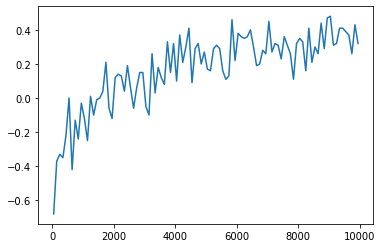

In [ ]:
from matplotlib import pyplot as plt

def averagewindow(R, d=1):
    n = len(R)
    t = []
    y = []
    for i in range(0,int(n/d)):
        t.append(np.mean(range(i*d,(i+1)*d)));
        y.append(np.mean(R[i*d:min(n,(i+1)*d)]))
    return t,y

window = 100
t,y = averagewindow(reward_per_ep, d=window)
plt.plot(t, y)

Record video in inference mode

In [ ]:
config['optimal'] = True                  # no learning anymore
config['render'] = True                   # render for recording
initQ_trained = lambda env: Q_trained     # dummy function that returns the trained Q table
prefix = 'gwenv_q'
vid_episodes = 5

# use wrapper to record videos
gwenv_vid = RecordVideo(gwenv, 
                        video_folder=video_folder,
                        episode_trigger=lambda ep: (ep < vid_episodes),
                        step_trigger=None,
                        video_length=0,
                        name_prefix=prefix
                        )

# use wrapper to record videos
Q_trained, reward_per_ep_test = QLearning(gwenv_vid,
                                          num_episodes=vid_episodes,
                                          initQ=initQ_trained,
                                          run_episode=run_episode_gwenv,
                                          config=config)

/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/record_video.py:79: UserWarning: WARN: Overwriting existing videos at /content/drive/MyDrive/CASAdvancedML/Videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  f"Overwriting existing videos at {self.video_folder} folder "
 20%|██        | 1/5 [00:00<00:00,  4.85it/s]

 grid_distance -2 2
direnemy [-1  0]
 grid_distance 0 2
direnemy [0 1]
 grid_distance 0 1
direnemy [0 1]
 grid_distance 0 -1
direnemy [ 0 -1]


 40%|████      | 2/5 [00:00<00:00,  4.42it/s]

 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 0 -1
direnemy [ 0 -1]
 grid_distance 1 0
direnemy [1 0]


 60%|██████    | 3/5 [00:00<00:00,  4.53it/s]

 grid_distance 0 1
direnemy [0 1]
 grid_distance 1 -2
direnemy [ 0 -1]


 80%|████████  | 4/5 [00:00<00:00,  4.36it/s]

 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]


100%|██████████| 5/5 [00:01<00:00,  4.12it/s]

 grid_distance 2 -3
direnemy [ 0 -1]
 grid_distance 3 -2
direnemy [1 0]
 grid_distance 2 -1
direnemy [1 0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance 0 1
direnemy [0 1]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]
 grid_distance -1 0
direnemy [-1  0]
 grid_distance 1 0
direnemy [1 0]


Play videos over some episodes

In [ ]:
show_videos(video_folder, prefix=prefix)

## Q-Learning on `GridWorldBlindEnemyEnv` or `GridWorldOracleEnemyEnv`

The task is to train our virtual agent with Q-Learning on one of the two custom environments previously created.
Analyze also results concerning different hyper-parameters of the algorithm (e.g., impact of learning rate, discount factor, etc.).

In [ ]:
# TO COMPLETE